In [1]:
using Interpolations
using Dierckx
using NPZ
using DifferentialEquations
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics
using PyCall

In [1707]:
using Sundials

In [2]:
imp = pyimport("importlib")

PyObject <module 'importlib' from '/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/importlib/__init__.py'>

In [3]:
pxr = pyimport("pixie_read_st")

PyObject <module 'pixie_read_st' from '/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [4]:
imp.reload(pxr)

PyObject <module 'pixie_read_st' from '/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [5]:
np = pyimport("numpy")

PyObject <module 'numpy' from '/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/numpy/__init__.py'>

## Metric tensor

In [2083]:
metricpath = "/net/scratch3/giannis_kx/FTLE/11/shaped_metric_coeff6.npz"

"/net/scratch3/giannis_kx/FTLE/11/shaped_metric_coeff6.npz"

In [2084]:
metric = npzread(metricpath);

We only keep covariant components

In [2202]:
grr = metric["grr_do"];
gtt = metric["gtt_do"];
grt = metric["grt_do"];
gpp = metric["gpp_do"];
Jac = metric["Jacobian"];
radial_grid = metric["radial_grid"];
pol_grid = metric["pol_grid"];

In [2203]:
rm = LinRange(radial_grid[1],radial_grid[end],size(radial_grid)[1]);
um = LinRange(pol_grid[1],pol_grid[end],size(pol_grid)[1]);

In [2087]:
#grrd = metric["grr_do"];
#gttd = metric["gtt_do"];
#grtd = metric["grt_do"];
#gppd = metric["gpp_do"];

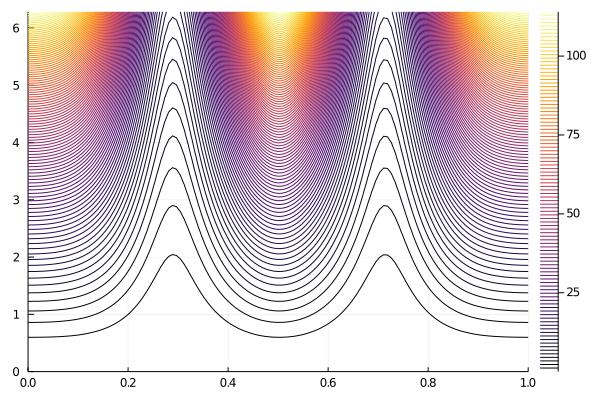

In [1959]:
Plots.contour(rn[1:end],un[1:end],gttN'[1:end,1:end],levels=100)

## Cylindrical Metric

In [1553]:
grr = zeros(length(radial_grid),length(pol_grid));
gtt = zeros(length(radial_grid),length(pol_grid));
grt = zeros(length(radial_grid),length(pol_grid));

In [1554]:
for i in 1:length(rm)
    for j in 1:length(um)
        grr[i,j] = 1
    end
end

In [1555]:
for i in 1:length(rm)
    for j in 1:length(um)
        gtt[i,j] = (rm[i])^2
    end
end

In [2204]:
grr_int = Interpolations.interpolate(grr, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
gtt_int = Interpolations.interpolate(gtt, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
grt_int = Interpolations.interpolate(grt, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
Jac_int = Interpolations.interpolate(Jac, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [2205]:
grr_sint = scale(grr_int,rm,um);
gtt_sint = scale(gtt_int,rm,um);
grt_sint = scale(grt_int,rm,um);
Jac_sint = scale(Jac_int,rm,um);

In [2206]:
grr_eint = extrapolate(grr_sint,(Line(),Line()));
gtt_eint = extrapolate(gtt_sint,(Line(),Line()));
grt_eint = extrapolate(grt_sint,(Line(),Line()));
Jac_eint = extrapolate(Jac_sint,(Line(),Line()));

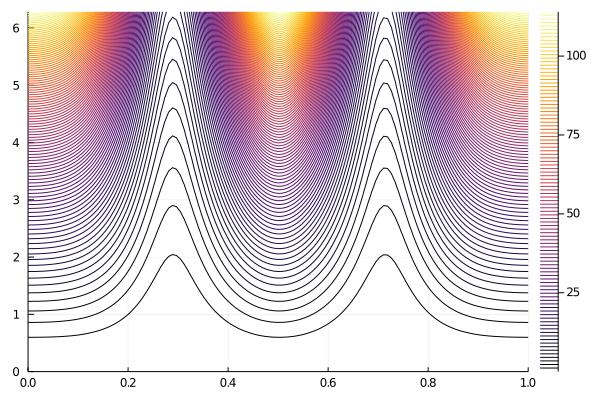

In [2092]:
Plots.contour(rn[1:end],un[1:end],gttN[1:end,1:end]',levels=100)

In [6]:
#filepath = "/net/scratch3/giannis_kx/pixie3d/tests/sawtooth/sawtooth2.scratch/pixie3d.h5"
#filepath = "/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/pixie3d.h5"
#filepath = "/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/pixie3d.h5"
filepath = "/lustre/scratch4/turquoise/giannis_kx/pixie3d/iter/db_tear/dt-nodiff-64nzd.scratch/"

"/lustre/scratch4/turquoise/giannis_kx/pixie3d/iter/db_tear/dt-nodiff-64nzd.scratch/"

In [7]:
tstart = 0 #800;
tend = 10 #980;
psi_max_ind = 97; # Avoid separatrix
psi_min_ind = 2; # Avoid magnetic axis
psi_range = psi_max_ind-psi_min_ind+1;
x0 = (0.9,0.44); # Initial guess for the X-point

In [8]:
pxr.pixieload(filepath * "pixie3d.h5")

In [9]:
psi = pxr.load_array(3,7,tstart,tend);
B1 = pxr.load_array(1,0,tstart,tend); # Contravariant components
B2 = pxr.load_array(1,1,tstart,tend);
B3 = pxr.load_array(1,2,tstart,tend);
B_1 = pxr.load_array(2,0,tstart,tend); # Covariant components
B_2 = pxr.load_array(2,1,tstart,tend);

In [10]:
psit = dropdims(mean(psi,dims=3),dims=3);
B1tc = dropdims(mean(B1,dims=3),dims=3);
B2tc = dropdims(mean(B2,dims=3),dims=3);
B_1tc = dropdims(mean(B_1,dims=3),dims=3);
B_2tc = dropdims(mean(B_2,dims=3),dims=3);

# Calculate JBp^2 term with cell components 
JBpsqc = (B1tc.*B_1tc) .+ (B2tc.*B_2tc);

In [11]:
# Make B-arrays into node-based quantities
# definitions of cell grid
num_r_cells = size(B3)[1];
num_u_cells = size(B3)[2];
num_phi_cells = size(B3)[3];
dn_r = (1.0/num_r_cells);
dn_u = ((2.0*pi)/num_u_cells);

# Cell-based grid
rc = LinRange(0.0+(dn_r/2.0),1.0-(dn_r/2.0),num_r_cells);
uc = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_u_cells);
phic = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_phi_cells);
tn = LinRange(0, size(B3)[4]-1,size(B3)[4]);

# Node-based grid
rn = LinRange(0.0,1.0,(num_r_cells+1));
un = LinRange(0.0,2.0*pi,(num_u_cells+1));
phin = LinRange(0.0,2.0*pi,(num_phi_cells+1));

# Node-based grid dimensions
rdim = size(psi)[1];
udim = size(psi)[2];
fidim = size(psi)[3];
tdim = size(psi)[4];

In [12]:
# Interpolate on cell-based grid
B1_int_cell = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B2_int_cell = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B3_int_cell = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_1_int_cell = Interpolations.interpolate(B_1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_2_int_cell = Interpolations.interpolate(B_2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
JBpsq_int_cell = Interpolations.interpolate(JBpsqc,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
#psit_int_cell = Interpolations.interpolate(psit,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));


B1_sint_cell = scale(B1_int_cell,rc,uc,phic,tn);
B2_sint_cell = scale(B2_int_cell,rc,uc,phic,tn);
B3_sint_cell = scale(B3_int_cell,rc,uc,phic,tn);
B_1_sint_cell = scale(B_1_int_cell,rc,uc,phic,tn);
B_2_sint_cell = scale(B_2_int_cell,rc,uc,phic,tn);
JBpsq_sint_cell = scale(JBpsq_int_cell,rc,uc,tn);
#psit_sint_cell = scale(psit_int_cell,rc,uc,tn);

B1_eint_cell = extrapolate(B1_sint_cell, (Line(),Periodic(),Periodic(),Line()));
B2_eint_cell = extrapolate(B2_sint_cell, (Line(),Periodic(),Periodic(),Line()));
B3_eint_cell = extrapolate(B3_sint_cell, (Line(),Periodic(),Periodic(),Line()));
B_1_eint_cell = extrapolate(B_1_sint_cell, (Line(),Periodic(),Periodic(),Line()));
B_2_eint_cell = extrapolate(B_2_sint_cell, (Line(),Periodic(),Periodic(),Line()));
JBpsq_eint_cell = extrapolate(JBpsq_sint_cell, (Line(),Periodic(),Line()));
#psit_eint_cell = extrapolate(psit_sint_cell, (Line(),Periodic(),Line()));

# Evaluate B on node grid
B1 = B1_eint_cell(rn,un,phin,tn);
B2 = B2_eint_cell(rn,un,phin,tn);
B3 = B3_eint_cell(rn,un,phin,tn);
B_1 = B_1_eint_cell(rn,un,phin,tn);
B_2 = B_2_eint_cell(rn,un,phin,tn);
JBpsqN = JBpsq_eint_cell(rn,un,tn);
#psit = psit_eint_cell(rn,un,tn);

# Here do the averaged fields corresponding to the node-projected ones-otherwise, the removal of the n=0 component from the perturbation is not exact
B1t = dropdims(mean(B1,dims=3),dims=3);
B2t = dropdims(mean(B2,dims=3),dims=3);
B3t = dropdims(mean(B3,dims=3),dims=3);
B_1t = dropdims(mean(B_1,dims=3),dims=3);
B_2t = dropdims(mean(B_2,dims=3),dims=3);

In [13]:
pxr.Calculation_of_Units_and_Sizes()
pxr.Axes_of_Interpolation(B3)
psi_min,norm = pxr.Normalization_numbers(psit,JBpsqN,x0);

In [18]:
size(JBpsqN)

(129, 65, 10)

In [22]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psi[:,:,1,1])
PyPlot.colorbar()
PyPlot.show()

LoadError: [91mPyError ($(Expr(:escape, :(ccall(#= /users/giannis_kx/.julia/packages/PyCall/tqyST/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'IndexError'>[39m
[91mIndexError('index 2 is out of bounds for size 2',)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/pyplot.py", line 2180, in colorbar[39m
[91m    ret = gcf().colorbar(mappable, cax = cax, ax=ax, **kw)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/figure.py", line 1844, in colorbar[39m
[91m    cb = cbar.colorbar_factory(cax, mappable, **kw)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/colorbar.py", line 1365, in colorbar_factory[39m
[91m    cb = Colorbar(cax, mappable, **kwargs)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/colorbar.py", line 933, in __init__[39m
[91m    ColorbarBase.__init__(self, ax, **kw)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/colorbar.py", line 326, in __init__[39m
[91m    self.draw_all()[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/colorbar.py", line 352, in draw_all[39m
[91m    self._config_axes(X, Y)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/colorbar.py", line 436, in _config_axes[39m
[91m    xy = self._outline(X, Y)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/matplotlib/colorbar.py", line 484, in _outline[39m
[91m    x = np.take(np.ravel(np.transpose(X)), ii)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 134, in take[39m
[91m    return _wrapfunc(a, 'take', indices, axis=axis, out=out, mode=mode)[39m
[91m  File "/usr/projects/hpcsoft/toss3/common/x86_64/anaconda/5.0.1-python-3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc[39m
[91m    return getattr(obj, method)(*args, **kwds)[39m


In [16]:
pxr.Normalization_numbers(psit,JBpsqN,x0)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [fill(0.0), fill(0.0), fill(0.0), fill(0.0), fill(0.0), fill(0.0), fill(0.0), fill(0.0), fill(0.0), fill(0.0)])

In [2243]:
B_1 = pxr.load_array(2,0,190,195);
B_2 = pxr.load_array(2,1,190,195);
B_3 = pxr.load_array(2,2,190,195);

In [2244]:
#psi=-psi;

In [2245]:
psit = dropdims(mean(psi,dims=3),dims=3);
B1t = dropdims(mean(B1,dims=3),dims=3);
B2t = dropdims(mean(B2,dims=3),dims=3);
B3t = dropdims(mean(B3,dims=3),dims=3);

In [2246]:
B_1t = dropdims(mean(B_1,dims=3),dims=3);
B_2t = dropdims(mean(B_2,dims=3),dims=3);
B_3t = dropdims(mean(B_3,dims=3),dims=3);

In [2247]:
JBpc = sqrt.((B1t.*B_1t) .+ (B2t.*B_2t));

In [2249]:
# definitions of cell grid
num_r_cells = size(B3)[1];
num_u_cells = size(B3)[2];
num_phi_cells = size(B3)[3];
dn_r = (1.0/num_r_cells);
dn_u = ((2.0*pi)/num_u_cells);

# Cell-based grid
rc = LinRange(0.0+(dn_r/2.0),1.0-(dn_r/2.0),num_r_cells);
uc = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_u_cells);
phic = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_phi_cells);
tn = LinRange(0, size(B3)[4]-1,size(B3)[4]);

# Node-based grid
rn = LinRange(0.0,1.0,(num_r_cells+1));
un = LinRange(0.0,2.0*pi,(num_u_cells+1));
phin = LinRange(0.0,2.0*pi,(num_phi_cells+1));

# Node-based grid dimensions
rdim = size(psi)[1];
udim = size(psi)[2];
fidim = size(psi)[3];
tdim = size(psi)[4];
psidim = 101;
ufdim = udim; # ufdim same as udim to avoid aliasing

# Straight field line coordinate grid
pn = LinRange(0.0,1.0,psidim);
ufn = LinRange(0.0,2.0*pi,ufdim);

In [2250]:
B1_int = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B2_int = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B3_int = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B1t_int = Interpolations.interpolate(B1t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B2t_int = Interpolations.interpolate(B2t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B3t_int = Interpolations.interpolate(B3t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [2251]:
B_1_int = Interpolations.interpolate(B_1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_2_int = Interpolations.interpolate(B_2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_3_int = Interpolations.interpolate(B_3,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_1t_int = Interpolations.interpolate(B_1t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_2t_int = Interpolations.interpolate(B_2t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B_3t_int = Interpolations.interpolate(B_3t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [2252]:
JBpc_int = Interpolations.interpolate(JBpc,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [2253]:
B1_sint = scale(B1_int,rc,uc,phic,tn);
B2_sint = scale(B2_int,rc,uc,phic,tn);
B3_sint = scale(B3_int,rc,uc,phic,tn);
B1t_sint = scale(B1t_int,rc,uc,tn);
B2t_sint = scale(B2t_int,rc,uc,tn);
B3t_sint = scale(B3t_int,rc,uc,tn);

In [2254]:
B_1_sint = scale(B_1_int,rc,uc,phic,tn);
B_2_sint = scale(B_2_int,rc,uc,phic,tn);
B_3_sint = scale(B_3_int,rc,uc,phic,tn);
B_1t_sint = scale(B_1t_int,rc,uc,tn);
B_2t_sint = scale(B_2t_int,rc,uc,tn);
B_3t_sint = scale(B_3t_int,rc,uc,tn);

In [2255]:
JBpc_sint = scale(JBpc_int,rc,uc,tn);

In [2256]:
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic(),Line()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic(),Line()));
B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic(),Line()));
B1t_eint = extrapolate(B1t_sint, (Line(),Periodic(),Line()));
B2t_eint = extrapolate(B2t_sint, (Line(),Periodic(),Line()));
B3t_eint = extrapolate(B3t_sint, (Line(),Periodic(),Line()));

In [2257]:
B_1_eint = extrapolate(B_1_sint, (Line(),Periodic(),Periodic(),Line()));
B_2_eint = extrapolate(B_2_sint, (Line(),Periodic(),Periodic(),Line()));
B_3_eint = extrapolate(B_3_sint, (Line(),Periodic(),Periodic(),Line()));
B_1t_eint = extrapolate(B_1t_sint, (Line(),Periodic(),Line()));
B_2t_eint = extrapolate(B_2t_sint, (Line(),Periodic(),Line()));
B_3t_eint = extrapolate(B_3t_sint, (Line(),Periodic(),Line()));

In [2258]:
JBpc_eint = extrapolate(JBpc_sint, (Line(),Periodic(),Line()));

In [2259]:
B1 = B1_eint(rn,un,phin,tn);
B2 = B2_eint(rn,un,phin,tn);
B3 = B3_eint(rn,un,phin,tn);
B1t = B1t_eint(rn,un,tn);
B2t = B2t_eint(rn,un,tn);
B3t = B3t_eint(rn,un,tn);

In [2260]:
B_1 = B_1_eint(rn,un,phin,tn);
B_2 = B_2_eint(rn,un,phin,tn);
B_3 = B_3_eint(rn,un,phin,tn);
B_1t = B_1t_eint(rn,un,tn);
B_2t = B_2t_eint(rn,un,tn);
B_3t = B_3t_eint(rn,un,tn);

In [2261]:
JBp = JBpc_eint(rn,un,tn);

In [2262]:
grr = grr_eint(rn,un);
grt = grt_eint(rn,un);
gtt = gtt_eint(rn,un);
Jac = Jac_eint(rn,un);

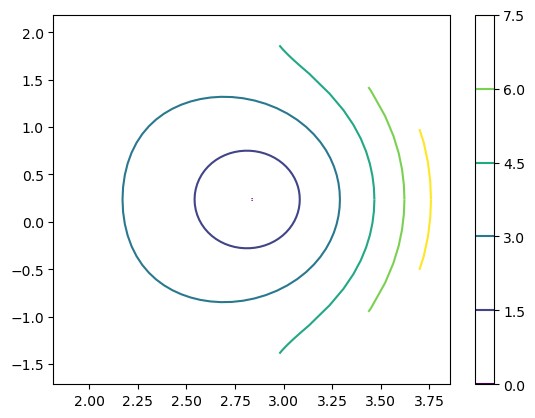

In [2263]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],Jac)
PyPlot.colorbar()
PyPlot.show()

In [2264]:
function dAdr(arr::Array{Float64,4},theta::Int,phi::Int,t::Int)
    dr = 1.0 / size(arr,1)
    p = arr[:,theta,phi,t]
    if theta<32
        mid = theta + convert(Int,(size(arr,2))/2)
    else
        mid = theta - convert(Int,(size(arr,2)-1)/2)
    end
    p_pi = arr[:,mid,phi,t]
    L = length(p)
    dpsidr = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidr[i] = (-p[3]+8*p[2]-8*p_pi[2]+p_pi[3])/(12.0*dr)
        elseif i==2
            dpsidr[i] = (-p[4]+8*p[3]-8*p[1]+p_pi[2])/(12.0*dr)
        elseif i==L-1
            dpsidr[i] = (p[L]-p[L-2])/(2.0*dr)
        elseif i==L-2 
            dpsidr[i] = (-p[L]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dr)
        elseif i==L
            dpsidr[i] = (p[L]-p[L-1])/dr
        else
            dpsidr[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dr)
        end
    end
    return dpsidr
end

function dAdt(arr::Array{Float64,4},r::Int,phi::Int,t::Int)
    dtheta = 2.0*pi / size(arr,2)
    p = arr[r,:,phi,t]
    L = length(p)
    dpsidtheta = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidtheta[i] = (-p[3]+8*p[2]-8*p[L-1]+p[L-2])/(12.0*dtheta)
        elseif i==2
            dpsidtheta[i] = (-p[4]+8*p[3]-8*p[1]+p[L-1])/(12.0*dtheta)
        elseif i==L-1
            dpsidtheta[L-1] = (-p[2]+8*p[1]-8*p[L-2]+p[L-3])/(12.0*dtheta)
        elseif i==L-2
            dpsidtheta[L-2] = (-p[1]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dtheta)
        elseif i==L
            dpsidtheta[L] = dpsidtheta[1]
        else
            dpsidtheta[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dtheta)
        end
    end
    return dpsidtheta
end 
    
function dpsi_dr(arr::Array{Float64,4})
    r_deriv = Float64[] 
    for theta in range(1,stop=size(arr,2))
        for phi in range(1,stop=size(arr,3))
            for t in range(1,stop=size(arr,4))
                r_deriv = append!(r_deriv,dAdr(arr,theta,phi,t))
            end
        end
    end
     # In Julia the convention in reshape is the opposite of Python
    return permutedims(reshape(r_deriv,(size(arr,1),size(arr,4),size(arr,3),size(arr,2))),(1,4,3,2))
end

function dpsi_dtheta(arr::Array{Float64,4})
    t_deriv = Float64[] 
    for r in range(1,stop=size(arr,1))
        for phi in range(1,stop=size(arr,3))
            for t in range(1,stop=size(arr,4))
                t_deriv = append!(t_deriv,dAdt(arr,r,phi,t))
            end
        end
    end
    return permutedims(reshape(t_deriv,(size(arr,2),size(arr,4),size(arr,3),size(arr,1))),(4,1,3,2))
end

dpsi_dtheta (generic function with 2 methods)

In [2265]:
function dAdr(arr::Array{Float64,3},theta::Int,t::Int)
    dr = 1.0 / size(arr,1)
    p = arr[:,theta,t]
    if theta<33
        mid = theta + convert(Int,(size(arr,2)-1)/2)
    else
        mid = theta - convert(Int,(size(arr,2)-1)/2)
    end
    p_pi = arr[:,mid,t]
    L = length(p)
    dpsidr = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidr[i] = (-p[3]+8*p[2]-8*p_pi[2]+p_pi[3])/(12.0*dr)
        elseif i==2
            dpsidr[i] = (-p[4]+8*p[3]-8*p[1]+p_pi[2])/(12.0*dr)
        elseif i==L-1
            dpsidr[i] = (p[L]-p[L-2])/(2.0*dr)
        elseif i==L-2 
            dpsidr[i] = (-p[L]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dr)
        elseif i==L
            dpsidr[i] = (p[L]-p[L-1])/dr
        else
            dpsidr[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dr)
        end
    end
    return dpsidr
end

function dAdt(arr::Array{Float64,3},r::Int,t::Int)
    dtheta = 2.0*pi / size(arr,2)
    p = arr[r,:,t]
    L = length(p)
    dpsidtheta = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidtheta[i] = (-p[3]+8*p[2]-8*p[L-1]+p[L-2])/(12.0*dtheta)
        elseif i==2
            dpsidtheta[i] = (-p[4]+8*p[3]-8*p[1]+p[L-1])/(12.0*dtheta)
        elseif i==L-1
            dpsidtheta[L-1] = (-p[2]+8*p[1]-8*p[L-2]+p[L-3])/(12.0*dtheta)
        elseif i==L-2
            dpsidtheta[L-2] = (-p[1]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dtheta)
        elseif i==L
            dpsidtheta[L] = dpsidtheta[1]
        else
            dpsidtheta[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dtheta)
        end
    end
    return dpsidtheta
end 
    
function dpsi_dr(arr::Array{Float64,3})
    r_deriv = Float64[] 
    for theta in range(1,stop=size(arr,2))
        for t in range(1,stop=size(arr,3))
            r_deriv = append!(r_deriv,dAdr(arr,theta,t))
        end
    end
     # In Julia the convention in reshape is the opposite of Python
    return permutedims(reshape(r_deriv,(size(arr,1),size(arr,3),size(arr,2))),(1,3,2))
end

function dpsi_dtheta(arr::Array{Float64,3})
    t_deriv = Float64[] 
    for r in range(1,stop=size(arr,1))
        for t in range(1,stop=size(arr,3))
            t_deriv = append!(t_deriv,dAdt(arr,r,t))
        end
    end
    return permutedims(reshape(t_deriv,(size(arr,2),size(arr,3),size(arr,1))),(3,1,2))
end

dpsi_dtheta (generic function with 2 methods)

In [2266]:
dpsidtheta = dpsi_dtheta(psi);
dpsidr = dpsi_dr(psi);
dpsidthetator = dpsi_dtheta(psit);
dpsidrtor = dpsi_dr(psit);

In [2267]:
X_int = Interpolations.interpolate(pxr.X,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Z_int = Interpolations.interpolate(pxr.Z,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
dpsidr_int = Interpolations.interpolate(dpsidr,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
dpsidtheta_int = Interpolations.interpolate(dpsidtheta,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
psi_int = Interpolations.interpolate(psi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B1_int = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B2_int = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B3_int = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
dpsidrt_int = Interpolations.interpolate(dpsidrtor,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
dpsidthetat_int = Interpolations.interpolate(dpsidthetator,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B1t_int = Interpolations.interpolate(B1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B2t_int = Interpolations.interpolate(B2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B3t_int = Interpolations.interpolate(B3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [2268]:
B_1_int = Interpolations.interpolate(B_1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_2_int = Interpolations.interpolate(B_2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_3_int = Interpolations.interpolate(B_3,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_1t_int = Interpolations.interpolate(B_1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_2t_int = Interpolations.interpolate(B_2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B_3t_int = Interpolations.interpolate(B_3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [2269]:
JBp_int = Interpolations.interpolate(JBp,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [2270]:
# Rescaling interpolation intervals
X_sint = scale(X_int, rn,un,phin);
Z_sint = scale(Z_int, rn,un,phin);
dpsidr_sint = scale(dpsidr_int, rn,un,phin,tn);
dpsidtheta_sint = scale(dpsidtheta_int, rn,un,phin,tn);
psi_sint = scale(psi_int, rn,un,phin,tn);
B1_sint = scale(B1_int, rn,un,phin,tn);
B2_sint = scale(B2_int, rn,un,phin,tn);
B3_sint = scale(B3_int, rn,un,phin,tn);
dpsidrt_sint = scale(dpsidrt_int, rn,un,tn);
dpsidthetat_sint = scale(dpsidthetat_int, rn,un,tn);
B1t_sint = scale(B1t_int, rn,un,tn);
B2t_sint = scale(B2t_int, rn,un,tn);
B3t_sint = scale(B3t_int, rn,un,tn);

In [2271]:
B_1_sint = scale(B_1_int, rn,un,phin,tn);
B_2_sint = scale(B_2_int, rn,un,phin,tn);
B_3_sint = scale(B_3_int, rn,un,phin,tn);
B_1t_sint = scale(B_1t_int, rn,un,tn);
B_2t_sint = scale(B_2t_int, rn,un,tn);
B_3t_sint = scale(B_3t_int, rn,un,tn);

In [2272]:
JBp_sint = scale(JBp_int, rn,un,tn);

In [2273]:
# Extrapolations on rescaled
X_eint = extrapolate(X_sint, (Line(),Periodic(),Periodic()));
Z_eint = extrapolate(Z_sint, (Line(),Periodic(),Periodic()));
dpsidr_eint = extrapolate(dpsidr_sint, (Line(),Periodic(),Periodic(),Line()));
dpsidtheta_eint = extrapolate(dpsidtheta_sint, (Line(),Periodic(),Periodic(),Line()));
psi_eint = extrapolate(psi_sint, (Line(),Periodic(),Periodic(),Line()));
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic(),Line()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic(),Line()));
B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic(),Line()));
dpsidrt_eint = extrapolate(dpsidrt_sint, (Line(),Periodic(),Line()));
dpsidthetat_eint = extrapolate(dpsidthetat_sint, (Line(),Periodic(),Line()));
B1t_eint = extrapolate(B1t_sint, (Line(),Periodic(),Line()));
B2t_eint = extrapolate(B2t_sint, (Line(),Periodic(),Line()));
B3t_eint = extrapolate(B3t_sint, (Line(),Periodic(),Line()));

In [2274]:
B_1_eint = extrapolate(B_1_sint, (Line(),Periodic(),Periodic(),Line()));
B_2_eint = extrapolate(B_2_sint, (Line(),Periodic(),Periodic(),Line()));
B_3_eint = extrapolate(B_3_sint, (Line(),Periodic(),Periodic(),Line()));
B_1t_eint = extrapolate(B_1t_sint, (Line(),Periodic(),Line()));
B_2t_eint = extrapolate(B_2t_sint, (Line(),Periodic(),Line()));
B_3t_eint = extrapolate(B_3t_sint, (Line(),Periodic(),Line()));

In [2275]:
JBp_eint = extrapolate(JBp_sint, (Line(),Periodic(),Line()));

In [91]:
function Flux_surface!(du,u,p,t)
    du[1] = -dpsidthetat_eint(u[1],u[2],p[1])/(sqrt((dpsidthetat_eint(u[1],u[2],p[1]))^2+((u[1])^2)*(dpsidrt_eint(u[1],u[2],p[1]))^2))
    du[2] = dpsidrt_eint(u[1],u[2],p[1])/(sqrt((dpsidthetat_eint(u[1],u[2],p[1]))^2+((u[1])^2)*(dpsidrt_eint(u[1],u[2],p[1]))^2))
    du[3] = -B3t_eint(u[1],u[2],p[1])/(sqrt((dpsidthetat_eint(u[1],u[2],p[1]))^2+(u[1]^2)*(dpsidrt_eint(u[1],u[2],p[1]))^2))
    
    end


function condition(u,t,integrator)
    abs(u[2]) - 2*pi 
end

function condition_zero(u,t,integrator)
    u[2] - 0.0
end

function condition_crossing(u,t,integrator)
    integrator.p[2] == 2.0
end 

function affect_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end


function affect!(integrator)
    terminate!(integrator)
end

cb1 = ContinuousCallback(condition,affect!,rootfind = true)
cb2 = ContinuousCallback(condition_zero,affect_cross!,rootfind = true)
cb3 = DiscreteCallback(condition_crossing,affect!)

function monitor(integrator)
    for (t,u) in tuples(integrator)
        @show t,u
    end
end

"""Solver call"""
function fs_integration(rs::Float64,us::Float64,time::Int)
    u0 = [rs,us,0.0]
    p = [time,0]
    tspan = (0.0,18.0)
    prob = ODEProblem(Flux_surface!,u0,tspan,p)
    cbs = CallbackSet(cb1,cb2,cb3)
    sol = solve(prob,Vern9(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    return sol
end

fs_integration

In [2163]:
function Flux_surface_metric!(du,u,p,t)
    alpha = 2.24
    du[1] = B1t_eint(u[1],u[2],p[1])/(sqrt((grr_eint(u[1],u[2])*((B1t_eint(u[1],u[2],p[1]))^2) + 2*grt_eint(u[1],u[2])*B1t_eint(u[1],u[2],p[1])*B2t_eint(u[1],u[2],p[1]) + gtt_eint(u[1],u[2])*((B2t_eint(u[1],u[2],p[1]))^2))))           
    du[2] = B2t_eint(u[1],u[2],p[1])/(sqrt((grr_eint(u[1],u[2])*((B1t_eint(u[1],u[2],p[1]))^2) + 2*grt_eint(u[1],u[2])*B1t_eint(u[1],u[2],p[1])*B2t_eint(u[1],u[2],p[1]) + gtt_eint(u[1],u[2])*((B2t_eint(u[1],u[2],p[1]))^2))))
    du[3] = B3t_eint(u[1],u[2],p[1])/(sqrt((grr_eint(u[1],u[2])*((B1t_eint(u[1],u[2],p[1]))^2) + 2*grt_eint(u[1],u[2])*B1t_eint(u[1],u[2],p[1])*B2t_eint(u[1],u[2],p[1]) + gtt_eint(u[1],u[2])*((B2t_eint(u[1],u[2],p[1]))^2))))
    #println("Sqrt:",(grr_eint(u[1],u[2])*((B1t_eint(u[1],u[2],p[1]))^2) + 2*grt_eint(u[1],u[2])*B1t_eint(u[1],u[2],p[1])*B2t_eint(u[1],u[2],p[1]) + gtt_eint(u[1],u[2])*((B2t_eint(u[1],u[2],p[1]))^2)))
    end


function condition(u,t,integrator)
    abs(u[2]) - 2*pi 
end

function condition_zero(u,t,integrator)
    u[2] - 0.0
end

function condition_crossing(u,t,integrator)
    integrator.p[2] == 2.0
end 

function affect_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end


function affect!(integrator)
    terminate!(integrator)
end

cb1 = ContinuousCallback(condition,affect!,rootfind = true)
cb2 = ContinuousCallback(condition_zero,affect_cross!,rootfind = true)
cb3 = DiscreteCallback(condition_crossing,affect!)

function monitor(integrator)
    for (t,u) in tuples(integrator)
        @show t,u
    end
end

"""Solver call"""
function fs_integration_metric(rs::Float64,us::Float64,time::Int)
    u0 = [rs,us,0.0]
    p = [time,0]
    tspan = (0.0,180.0)
    prob = ODEProblem(Flux_surface_metric!,u0,tspan,p)
    cbs = CallbackSet(cb1,cb2,cb3)
    integrator = init(prob,Vern9(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    sol = solve(prob,Vern9(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    #sol = solve(prob,CVODE_BDF(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    #monitor(integrator)
    return sol
end

fs_integration_metric

In [2289]:
function Flux_surface_mixed!(du,u,p,t)
    du[1] = B1t_eint(u[1],u[2],p[1])/JBp_eint(u[1],u[2],p[1])
    du[2] = B2t_eint(u[1],u[2],p[1])/JBp_eint(u[1],u[2],p[1])
    du[3] = B3t_eint(u[1],u[2],p[1])/JBp_eint(u[1],u[2],p[1])
    end


function condition(u,t,integrator)
    abs(u[2]) - 2*pi 
end

function condition_zero(u,t,integrator)
    u[2] - 0.0
end

function condition_crossing(u,t,integrator)
    integrator.p[2] == 2.0
end 

function affect_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end


function affect!(integrator)
    terminate!(integrator)
end

cb1 = ContinuousCallback(condition,affect!,rootfind = true)
cb2 = ContinuousCallback(condition_zero,affect_cross!,rootfind = true)
cb3 = DiscreteCallback(condition_crossing,affect!)

function monitor(integrator)
    for (t,u) in tuples(integrator)
        @show t,u
    end
end

"""Solver call"""
function fs_integration_mixed(rs::Float64,us::Float64,time::Int)
    u0 = [rs,us,0.0]
    p = [time,0]
    tspan = (0.0,180.0)
    prob = ODEProblem(Flux_surface_mixed!,u0,tspan,p)
    cbs = CallbackSet(cb1,cb2,cb3)
    integrator = init(prob,Vern9(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    sol = solve(prob,Vern9(),callback=cbs,reltol=1.e-10,abstol=1.e-10)
    return sol
end

fs_integration_mixed

In [2290]:
pxr.Axes_of_Interpolation(B3)
pxr.Grid_Interpolations(psit,-dpsidtheta,dpsidr,B3)
pxr.Calculation_of_Units_and_Sizes()

In [2130]:
imp.reload(pxr)

PyObject <module 'pixie_read_st' from '/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [98]:
A = pxr.findLevelsZero(B1t,B2t,0);

In [1269]:
B = pxr.findXpoint(B1t,B2t,4)

([2.3329351205716793], [-1.566948913539649])

In [1270]:
C = pxr.pntCnvInGrid_shaped(B[1][1],B[2][1])

(0.9253119216350564, 4.776827462904693)

In [1271]:
#initr = 0.9016962856211719;
#initu = 4.573940261846947;

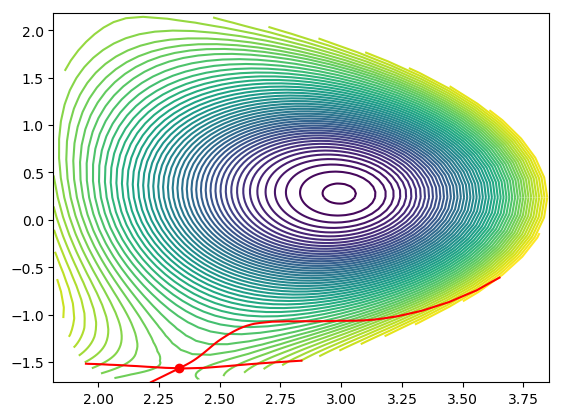

In [1272]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psit[:,:,4],60)
#PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psi[:,:,1,3],60)
#PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],-dpsidthetator[:,:,3],levels=[0.0],"b")
#PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B2t[:,:,3],levels=[0.0],"r")
PyPlot.plot(B[1][1],B[2][1],"ro")
PyPlot.plot(A[1],A[2],"r")
PyPlot.plot(A[3],A[4],"r")
#PyPlot.axhline(y=-1.2)
#PyPlot.plot(X_eint(C[1],C[2],0.),Z_eint(C[1],C[2],0.),"gx")
#PyPlot.plot(X_eint(initr, initu,0.0),Z_eint(initr, initu,0.0),"x")
PyPlot.show()

In [2291]:
psi_min,norm = pxr.Normalization_numbers(psit,-dpsidthetator,dpsidrtor);

In [2292]:
r_of_psi = pxr.create_r_psi_list(psit,-dpsidthetator,dpsidrtor);

In [2293]:
r_of_psi_array = r_of_psi[1];

In [2294]:
rmaxis = r_of_psi[2];

In [2295]:
umaxis = r_of_psi[3];

In [1884]:
psi_min_ind = 2;
psi_max_ind = 100;
psi_range = psi_max_ind-psi_min_ind+1;

In [106]:
function q_profile()
    q = []
    for t in range(0, stop=tdim-1)
        for r in r_of_psi_array[t+1,psi_min_ind:psi_max_ind]
            sol = fs_integration_metric(r,0.0,t)
            append!(q, last(sol[3,length(sol.t)])/(2.0*pi))
        end
    end
    q_fun = reshape(q,psi_range,tdim)
    return q_fun
end

q_profile (generic function with 1 method)

In [122]:
q_tmp = q_profile();

In [108]:
q = Float64.(q_tmp);

In [109]:
function stretch_q(q_array::Array{Float64,2})
    psin_list = LinRange(0.0,1.0,psidim)
    small_grid = LinRange(psin_list[psi_min_ind],psin_list[psi_max_ind],psi_range)
    q_str = []
    for t in 1:size(q_array)[2]
        q = Float64.(q_array[:,t])
        q_int = Interpolations.interpolate(q,(BSpline(Cubic(Line(OnGrid())))))
        q_sint = scale(q_int,small_grid)
        q_eint = extrapolate(q_sint,Line())
        for i in psin_list
            append!(q_str,q_eint(i))
        end
    end
    q_str = reshape(q_str,(length(psin_list),size(q_array,2)))    
    return q_str
end

stretch_q (generic function with 1 method)

In [110]:
q_str = stretch_q(q);

In [111]:
size(q_str)

(101, 2)

In [112]:
function resize_q(arr::Array{Any,2})
    big_arr = []
    for psi_ind in 1:psidim
        for uf_ind in 1:ufdim 
            for t_ind in 1:tdim
                for fi_ind in 1:fidim
                    append!(big_arr, arr[psi_ind,t_ind])
                end
            end
        end
    end
    
    aug_arr = permutedims(reshape(big_arr,fidim,tdim,ufdim,psidim),(4,3,1,2))
    return aug_arr
end

resize_q (generic function with 1 method)

In [113]:
Q = resize_q(q_str);

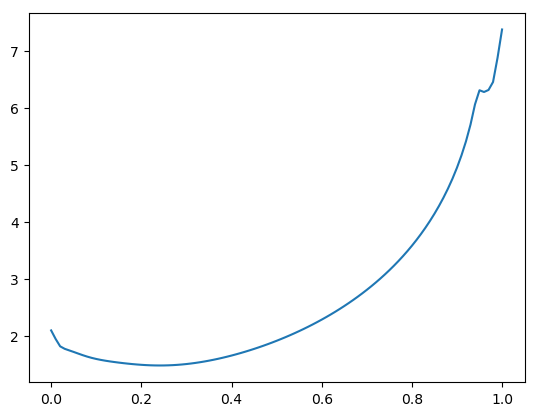

In [117]:
PyPlot.plot(LinRange(0.0,1.0,101),Q[:,1,1,2])
#PyPlot.ylim(0.0,1.8)
PyPlot.show()

In [619]:
npzwrite("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/" * "Q.npy",Float64.(Q))

In [2079]:
function new_grid()
    uf_pts = LinRange(0.0,2*pi,udim)
    psin = LinRange(0.0,1.0,101)
    Grid_Dict = Dict{Tuple{Int64,Float64,Float64},Tuple{Float64,Float64}}()
    for t in range(0, stop=tdim-1)
        for (i,r) in enumerate(r_of_psi_array[t+1,psi_min_ind:psi_max_ind])
            sol = fs_integration_mixed(r,0.0,t)
            uf_sol = sol[3,:]
            q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
            uf_rsc = uf_sol/q_redef
            l = sol.t
            l_of_uf_rsc = Spline1D(sort!(uf_rsc[1:end-1]),l[1:end-1],k=3,bc="extrapolate",s=1e-4)
            ls = l_of_uf_rsc(uf_pts)
            polar_coords = sol(ls,idxs=1:2)
            psi_val = pn[i+psi_min_ind-1]
            for j in 1:udim
                Grid_Dict[(t,psi_val,uf_pts[j])] = (polar_coords[j][1],polar_coords[j][2])
            end
        end
    end
    return Grid_Dict
end         

new_grid (generic function with 1 method)

In [2080]:
GD = new_grid()

Dict{Tuple{Int64,Float64,Float64},Tuple{Float64,Float64}} with 32175 entries:
  (0, 0.27, 0.0)      => (0.519345, 0.00564077)
  (4, 0.5, 1.1781)    => (0.419997, -1.38989)
  (1, 0.88, 2.45437)  => (0.721255, -2.7438)
  (4, 0.03, 3.63247)  => (0.0836622, -4.88267)
  (0, 0.12, 3.23977)  => (0.168685, -3.47525)
  (1, 0.48, 5.10509)  => (0.459614, -4.96391)
  (1, 0.94, 4.12334)  => (0.826954, -3.72941)
  (1, 0.39, 0.392699) => (0.540533, -0.360783)
  (2, 0.94, 5.79231)  => (0.768129, -5.15885)
  (1, 0.22, 2.65072)  => (0.256787, -2.87646)
  (2, 0.05, 4.02517)  => (0.131874, -4.75735)
  (4, 0.66, 6.18501)  => (0.723943, -6.15667)
  (0, 0.93, 1.86532)  => (0.71987, -2.07248)
  (0, 0.52, 0.490874) => (0.573079, -0.528613)
  (0, 0.62, 2.74889)  => (0.560277, -2.98898)
  (1, 0.48, 3.43612)  => (0.476943, -3.42329)
  (1, 0.1, 1.5708)    => (0.174029, -1.34747)
  (0, 0.16, 0.294524) => (0.41989, -0.222198)
  (3, 0.04, 3.04342)  => (0.0391061, -3.87987)
  (4, 0.55, 5.98866)  => (0.650312, -5.95803

### Check function projection

In [2081]:
B3P = []
uf_pts = LinRange(0.0,2*pi,udim)
phi_pts = LinRange(0.0,2*pi,fidim)
for t in 1:tdim
    for p in pn[psi_min_ind:psi_max_ind]
        for uf in uf_pts
            for phi in phi_pts
                r = GD[Int64(t-1),round(p,digits=2),Float64(uf)][1]
                u = GD[Int64(t-1),round(p,digits=2),Float64(uf)][2]
                Bval = psi_eint(r,u,phi,t-1)
                append!(B3P,Bval)
            end
        end
    end
end
B3N = permutedims(reshape(B3P,size(phi_pts)[1],size(uf_pts)[1],psi_range,tdim),(3,2,1,4));

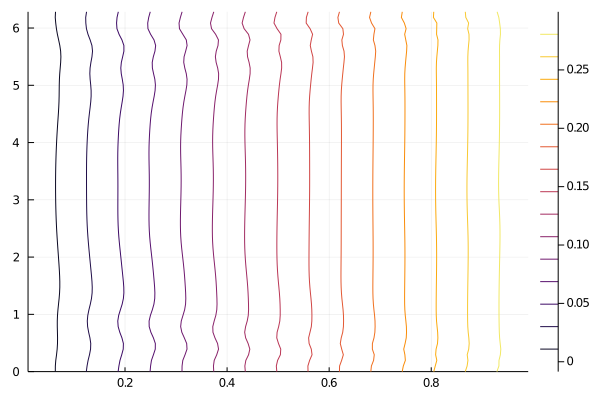

In [2082]:
Plots.contour(pn[psi_min_ind:psi_max_ind],un,B3N[:,:,1,4]')

## Check $\theta_f$ angle in integration

In [2137]:
println(r_of_psi_array[2,51])

0.6462247626505305


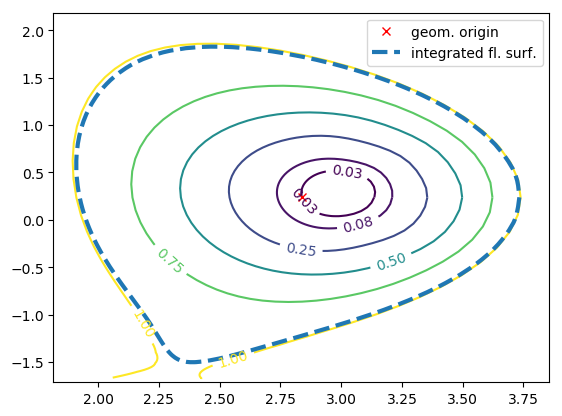

In [2296]:
t = 2
sol = fs_integration_mixed(r_of_psi_array[t,100],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
CS = PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],(psi[:,:,1,t].-psi_min[t])/(norm[t].-psi_min[t]),levels=[0.03,0.08,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(pxr.X[1,1,1],pxr.Z[1,1,1],"rx",label="geom. origin")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
#PyPlot.xlim(1.6,1.8)
#PyPlot.ylim(-0.2,0.2)
PyPlot.legend()
PyPlot.show()

In [77]:
q_redef = last(sol[3,length(sol.t)])/(2.0*pi);
uf_rsc = sol[3,:]./q_redef;

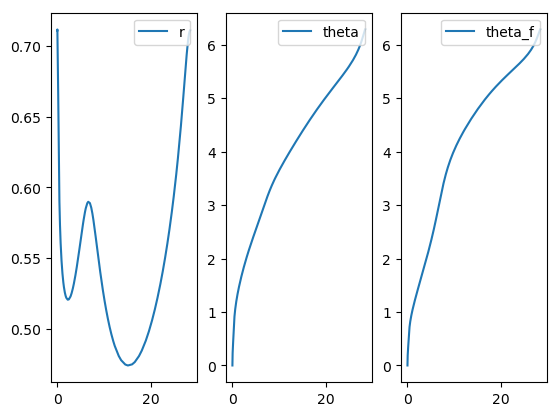

In [78]:
fig,(ax1,ax2,ax3) = PyPlot.subplots(1,3)
ax1.plot(sol.t,sol[1,:],label="r")
ax1.legend(loc="upper right")
ax2.plot(sol.t,sol[2,:],label="theta")
ax2.legend(loc="upper right")
ax3.plot(sol.t,uf_rsc,label="theta_f")
ax3.legend(loc="upper right")
PyPlot.show()

Indeed, $\theta_f$ is in $[0,2\pi]$, even if $\theta$ is not.

## Try to work with $\theta_f(r,\theta)$

In [382]:
time = 5
r_list = []#repeat([r_of_psi_array[time,1]],size(un)[1])
u_list = []#convert(Array,un)
uf_list = []#repeat([0.0],size(un)[1])
q_list = []
for r in r_of_psi_array[time,psi_min_ind+1:psi_max_ind-5]
    sol = fs_integration(r,0.0,time-1)
    L = length(sol.t)
    r_sol = sol[1,1:end-1] 
    u_sol = sol[2,1:end-1]
    uf_sol = sol[3,1:end-1]
    q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
    uf_rsc_sol = uf_sol/q_redef
    l = sol.t
    for i in 1:(L-1)
        append!(r_list,r_sol[i])
        append!(u_list,u_sol[i])
        append!(uf_list,uf_rsc_sol[i])
    end
end

In [383]:
r_or = r_of_psi_array[time,1]

0.039062499999999875

In [384]:
for u in un
    append!(r_list,r_or)
    append!(u_list,0.0)
    append!(uf_list,u)
end

In [385]:
A = cat(dims=2,r_list,u_list)
ufl = Float64.(uf_list);
rupoints = Float64.(A');

In [402]:
itp = ScatteredInterpolation.interpolate(ThinPlate(),rupoints,ufl,smooth=0.8)

ScatteredInterpolation.RBFInterpolant{Array{Float64,1},Array{Float64,2},Polyharmonic{Int64},Distances.Euclidean}([-2.252965084993294, -1.701393677542516, -1.2243673328567302, -0.7699010851700153, -0.5833046896890497, -0.3181966517809501, -0.22008409200950593, -0.15549644491405903, -0.058799545788389876, -0.01003551613296177  …  3.3337742155590697, 3.456492678589921, 3.579211141620772, 3.701929604651625, 3.824648067682477, 3.9473665307133268, 4.070084993744177, 4.1928034567750485, 4.315521919805854, 4.438240382836715], [0.09162091647186016 0.09158912243764403 … 0.039062499999999875 0.039062499999999875; 0.0 0.04793452088152157 … 0.0 0.0], Polyharmonic{Int64}(2), Distances.Euclidean(0.0))

In [392]:
rn2 = LinRange(r_or,1.0,size(rn)[1])

129-element LinRange{Float64}:
 0.0390625,0.0465698,0.0540771,0.0615845,…,0.977478,0.984985,0.992493,1.0

In [403]:
ufarr = []
for r in rn
    for u in un
        uf = ScatteredInterpolation.evaluate(itp,[r,u])
        append!(ufarr,uf)
    end
end
ufarr = permutedims(reshape(ufarr,size(un)[1],size(rn)[1]),(2,1));

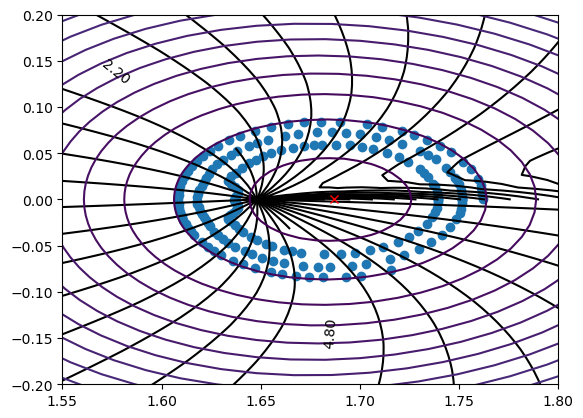

In [404]:
dx = X_eint(r_or,0.0,0.0)-pxr.X[1,1,1]
xval = [X_eint(r_list[i],u_list[i],0.0) for i in 1:200]
zval = [Z_eint(r_list[i],u_list[i],0.0) for i in 1:200]
PyPlot.scatter(xval,zval)
CS = PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],ufarr,40,colors="k")
PyPlot.clabel(CS,fmt="%1.2f")
#PyPlot.plot(X_eint(r_list,u_list,0.0),Z_eint(r_list,u_list,0.0))
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psit[:,:,time],80)
PyPlot.plot(X_eint(r_or,0.0,0.0),Z_eint(r_or,0.0,0.0),"rx")
PyPlot.xlim(1.55,1.8)
PyPlot.ylim(-0.2,0.2)
PyPlot.show()

In [288]:
ScatteredInterpolation.evaluate(itp,[r_or,0.0])

1-element Array{Float64,1}:
 0.037634250339358744

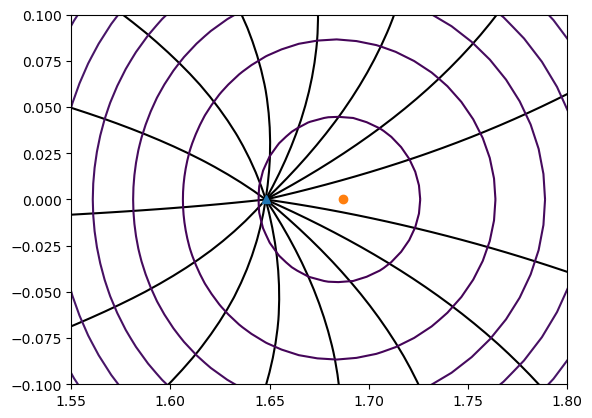

In [330]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],ufarr,20,colors="k")
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psit[:,:,time],80)
PyPlot.plot(pxr.X[1,1,1],pxr.Z[1,1,1],"^")
PyPlot.plot(X_eint(r_or,0.0,0.0),Z_eint(r_or,0.0,0.0),"o")
PyPlot.xlim(1.55,1.8)
PyPlot.ylim(-0.1,0.1)
PyPlot.show()

In [356]:
x=0.01
spl = try
    Spline2D(r_list,u_list,uf_list,s=x)
catch
    try
        x = 2*x
        Spline2D(r_list,u_list,uf_list,s=x)
    catch
    end
end

Spline2D([0.01689005869522297, 0.01689005869522297, 0.01689005869522297, 0.01689005869522297, 0.08501485843650679, 0.1349369290611291, 0.21403666649951025, 0.40054158919361904, 0.4533395292575789, 0.4728019119418806, 0.49128817052915064, 0.5112583415708771, 0.5380226963831375, 0.6851587856789847, 0.6851587856789847, 0.6851587856789847, 0.6851587856789847], [0.0, 0.0, 0.0, 0.0, 0.28234300937449375, 0.7455469716318955, 1.4286609889710447, 2.424660777520535, 3.1064757738177375, 3.4700547011374945, 3.7156668133706496, 4.2865652501517255, 4.835390420709863, 5.332474465076947, 5.836635769807253, 6.283185307179585, 6.283185307179585, 6.283185307179585, 6.283185307179585], [-0.09240601334234141, -0.014424914394403913, 0.00183286868744784, -0.00015289175919127622, 0.000539820889205697, 0.0003037808544845143, 0.0002741945020510162, 0.00019084106335886644, 0.0014765864623443904, 0.0020192445467894647  …  6.2833655718177726, 6.283006671799668, 6.283234611397664, 6.283177662966715, 6.28339903569387

In [359]:
uf_array = Dierckx.evalgrid(spl,rn.+r_or,un);

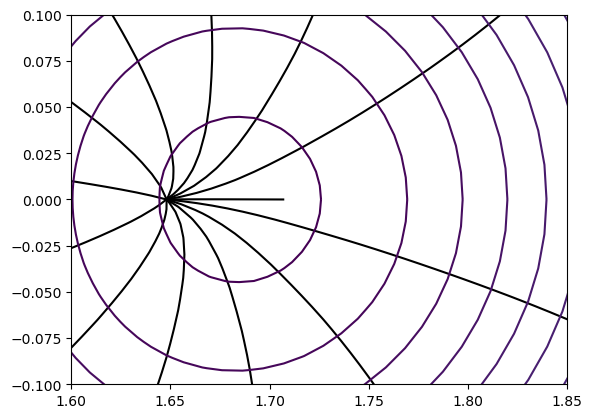

In [361]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],uf_array,20,colors="k")
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psit[:,:,time],60)
PyPlot.xlim(1.6,1.85)
PyPlot.ylim(-0.1,0.1)
PyPlot.show()

In [412]:
U = StraightAngleArray(r_list,u_list,uf_list)

129×65 Array{Any,2}:
  3.22563    2.35664    1.69298   …  5.85379  5.99684  6.14052  6.28628
  3.13739    2.25596    1.60564      5.85754  5.99912  6.14132  6.28564
  3.04519    2.15287    1.51843      5.86142  6.00151  6.14221  6.28506
  2.94815    2.0475     1.43156      5.86543  6.00401  6.14319  6.28456
  2.84489    1.94001    1.34527      5.86957  6.00662  6.14425  6.28412
  2.73259    1.83069    1.25982   …  5.87383  6.00933  6.1454   6.28374
  2.606      1.71991    1.17548      5.87822  6.01215  6.14663  6.28343
  2.47113    1.60815    1.09258      5.88274  6.01507  6.14793  6.28317
  2.33159    1.49598    1.01144      5.88737  6.01809  6.14932  6.28297
  2.18956    1.38408    0.932427     5.89212  6.02121  6.15079  6.28282
  2.04671    1.2732     0.85591   …  5.89699  6.02442  6.15232  6.28273
  1.90453    1.1642     0.782292     5.90197  6.02774  6.15394  6.28268
  1.76455    1.05804    0.712008     5.90708  6.03114  6.15562  6.28267
  ⋮                               ⋱        

## Work with Cartesian Coordinates

In [372]:
time = 5
X_list = []
Z_list = []
uf_list = []
for r in r_of_psi_array[time,psi_min_ind+5:psi_max_ind-5]
    sol = fs_integration(r,0.0,time-1)
    L = length(sol.t)
    r_sol = sol[1,1:end-1] 
    u_sol = sol[2,1:end-1]
    uf_sol = sol[3,1:end-1]
    q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
    uf_rsc_sol = uf_sol/q_redef
    l = sol.t
    for i in 1:(L-1)
        x = X_eint(r_sol[i],u_sol[i],0.0)
        z = Z_eint(r_sol[i],u_sol[i],0.0)
        append!(X_list,x)
        append!(Z_list,z)
        append!(uf_list,uf_rsc_sol[i])
    end
end

In [150]:
for u in un
    x = X_eint(r_or,u,0.0)
    z = Z_eint(r_or,u,0.0)
    append!(X_list,x)
    append!(Z_list,z)
    append!(uf_list,u)
end

In [373]:
A = cat(dims=2,X_list,Z_list)
ufl = Float64.(uf_list);
XZpoints = Float64.(A');

In [369]:
itp = ScatteredInterpolation.interpolate(ThinPlate(),XZpoints,ufl,smooth=0.8)

ScatteredInterpolation.RBFInterpolant{Array{Float64,1},Array{Float64,2},Polyharmonic{Int64},Distances.Euclidean}([-4.222833750127474, -3.618611012542221, -3.288885740938679, -3.0847492436955934, -2.605109822264283, -2.3042057071874065, -1.9380655618825466, -1.729384633781118, -1.3601350503537086, -1.1698692529878014  …  -0.25186747445015195, -0.189047115946229, -0.061981061510780214, 0.16710663912401935, 0.4171765568833634, 1.0258500902628853, 2.5370816822435347, 2.965276093552461, 3.0659516900598702, 3.0756230674243117], [1.4643612028572768e-19 0.00931362782645206 … -0.00019177558097238355 -2.5305494508867465e-15; 1.7793416891012155 1.7788781499382236 … 2.187802280767865 2.1878115660960744], Polyharmonic{Int64}(2), Distances.Euclidean(0.0))

In [365]:
Xn = LinRange(minimum(pxr.X[:,:,1]),maximum(pxr.X[:,:,1]),100);
Zn = LinRange(minimum(pxr.Z[:,:,1]),maximum(pxr.Z[:,:,1]),100);

In [370]:
ufarr = []
for x in Xn
    for z in Zn
        uf = ScatteredInterpolation.evaluate(itp,[x,z])
        append!(ufarr,uf)
    end
end
ufarr = permutedims(reshape(ufarr,100,100),(2,1));

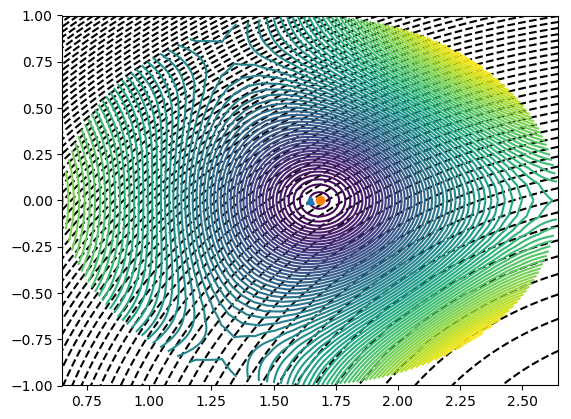

In [371]:
PyPlot.contour(Xn,Zn,ufarr,80,colors="k")
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psit[:,:,time],80)
PyPlot.plot(pxr.X[1,1,1],pxr.Z[1,1,1],"^")
PyPlot.plot(X_eint(r_or,0.0,0.0),Z_eint(r_or,0.0,0.0),"o")
#PyPlot.xlim(1.6,1.8)
#PyPlot.ylim(-0.1,0.1)
PyPlot.show()

In [337]:
#RNJ=rn'.*ones(size(un));
#UNJ=ones(size(rn))'.*un;

In [336]:
#tri = pyimport("matplotlib.tri") 

In [335]:
#triangObj = tri.Triangulation(X_list,Z_list)

In [334]:
#tcp = tri.CubicTriInterpolator(triangObj,uf_list)

In [341]:
#np = pyimport("numpy")

In [340]:
#RN,UN = np.meshgrid(rn,un)

In [339]:
#size(RN)

In [338]:
#uf_arr = tcp(RN',UN')

In [342]:
#si = pyimport("scipy.interpolate")

In [343]:
# mask invalid values
#uf_ma = pycall(np.ma.masked_invalid,Any,uf_arr);
# get only valid values
#x1 = RN'[.!uf_ma.mask];
#y1 = UN'[.!uf_ma.mask];
#new_uf = uf_arr[.!uf_ma.mask];

In [344]:
#uf_rav = np.ravel(new_uf);

In [345]:
#uf_GD = si.griddata((x1,y1),uf_rav,(RN',UN'),method="cubic");

In [347]:
#PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],uf_GD,20,colors="k")
#PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psi[:,:,1,15],80)
#PyPlot.xlim(1.6,1.8)
#PyPlot.ylim(-0.1,0.1)
#PyPlot.show()

In [331]:
x=0.01
spl = try
    Spline2D(r_list,u_list,uf_list,s=x)
catch
    try
        x = 2*x
        Spline2D(r_list,u_list,uf_list,s=x)
    catch
    end
end

Spline2D([0.01689005869522297, 0.01689005869522297, 0.01689005869522297, 0.01689005869522297, 0.08501485843650679, 0.1349369290611291, 0.21403666649951025, 0.40054158919361904, 0.4533395292575789, 0.4728019119418806, 0.49128817052915064, 0.5112583415708771, 0.5380226963831375, 0.6851587856789847, 0.6851587856789847, 0.6851587856789847, 0.6851587856789847], [0.0, 0.0, 0.0, 0.0, 0.28234300937449375, 0.7455469716318955, 1.4286609889710447, 2.424660777520535, 3.1064757738177375, 3.4700547011374945, 3.7156668133706496, 4.2865652501517255, 4.835390420709863, 5.332474465076947, 5.836635769807253, 6.283185307179585, 6.283185307179585, 6.283185307179585, 6.283185307179585], [-0.09240601334234141, -0.014424914394403913, 0.00183286868744784, -0.00015289175919127622, 0.000539820889205697, 0.0003037808544845143, 0.0002741945020510162, 0.00019084106335886644, 0.0014765864623443904, 0.0020192445467894647  …  6.2833655718177726, 6.283006671799668, 6.283234611397664, 6.283177662966715, 6.28339903569387

In [332]:
uf_array = Dierckx.evalgrid(spl,rn,un)

129×65 Array{Float64,2}:
 -0.092406    0.362294  0.771419  …  5.19892  5.53689  5.91522  6.33527
 -0.092406    0.362294  0.771419     5.19892  5.53689  5.91522  6.33527
 -0.092406    0.362294  0.771419     5.19892  5.53689  5.91522  6.33527
 -0.071767    0.329119  0.692794     5.30139  5.60855  5.94909  6.32358
 -0.0516493   0.293916  0.610756     5.40936  5.68409  5.98509  6.31221
 -0.0359001   0.263153  0.540491  …  5.50293  5.7496   6.01661  6.30332
 -0.0239514   0.236482  0.480893     5.58334  5.8059   6.04398  6.29658
 -0.015235    0.213558  0.430857     5.65181  5.85386  6.06754  6.29169
 -0.00918271  0.194034  0.389278     5.70956  5.8943   6.08762  6.2883
 -0.00522633  0.177563  0.355051     5.75782  5.92808  6.10457  6.2861
 -0.00279771  0.163798  0.327071  …  5.79781  5.95603  6.11872  6.28476
 -0.0013288   0.152393  0.304232     5.83076  5.97901  6.13041  6.28396
 -0.0003654   0.143018  0.285557     5.85779  5.99779  6.13996  6.28344
  ⋮                               ⋱      

In [166]:
spl(0.07,0.0)

-0.00309263515162983

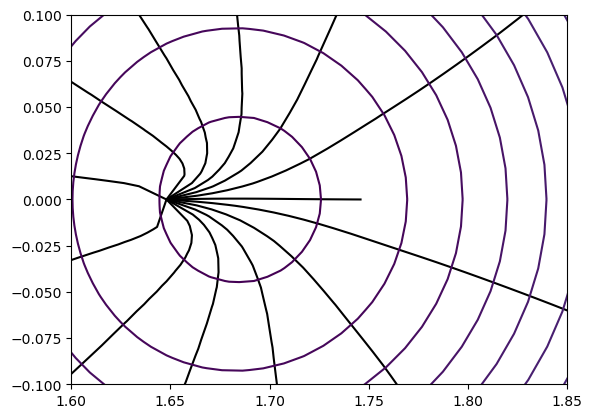

In [333]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],uf_array,20,colors="k")
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psit[:,:,5],60)
PyPlot.xlim(1.6,1.85)
PyPlot.ylim(-0.1,0.1)
PyPlot.show()

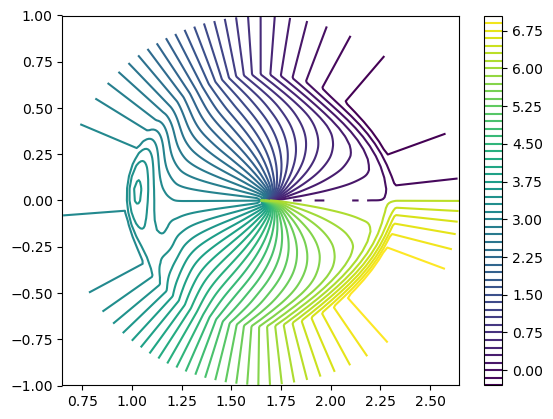

In [438]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],uf_array,50)
PyPlot.colorbar()
PyPlot.show()

## Work with $\theta_f$ array

In [411]:
function StraightAngleArray(r_list::Array{Any,1},u_list::Array{Any,1},uf_list::Array{Any,1},s = 0.8)
    A = cat(dims=2,r_list,u_list)
    ufl = Float64.(uf_list);
    rupoints = Float64.(A');
    itp = ScatteredInterpolation.interpolate(ThinPlate(),rupoints,ufl,smooth=s);
    ufarr = []
    for r in rn
        for u in un
            uf = ScatteredInterpolation.evaluate(itp,[r,u])
            append!(ufarr,uf)
        end
    end
    ufarr = permutedims(reshape(ufarr,size(un)[1],size(rn)[1]),(2,1));
    return ufarr
end

StraightAngleArray (generic function with 4 methods)

In [476]:
function straight_angle_array_creation()
    SA = Array{Float64}(undef,(rdim,udim,0))
    for time in 1:tdim
        r_list = []
        u_list = []
        uf_list = []
        for r_ind in psi_min_ind:psi_max_ind
            sol = fs_integration(r_of_psi_array[time,r_ind],0.0,time-1)
            L = length(sol.t)
            r_sol = sol[1,1:end-1] 
            u_sol = sol[2,1:end-1]
            uf_sol = sol[3,1:end-1]
            q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
            uf_rsc_sol = uf_sol/q_redef
            l = sol.t
            for i in 1:(L-1)
                append!(r_list,r_sol[i])
                append!(u_list,u_sol[i])
                append!(uf_list,uf_rsc_sol[i])
            end
        end
        SA_temp = StraightAngleArray(r_list,u_list,uf_list)
        SA = cat(dims=3,SA,SA_temp)
    end
    return SA
end         

straight_angle_array_creation (generic function with 1 method)

In [477]:
SA = straight_angle_array_creation()

129×65×6 Array{Any,3}:
[:, :, 1] =
  0.0401393   0.17234    0.305371  …  5.84437  5.9755   6.09941  6.20442
  0.0374052   0.168558   0.300604     5.85065  5.98124  6.10499  6.20993
  0.0347222   0.164814   0.295852     5.85688  5.98687  6.11043  6.21531
  0.0320956   0.16111    0.291119     5.86306  5.9924   6.11573  6.22055
  0.029531    0.157453   0.286406     5.86918  5.99782  6.12088  6.22563
  0.0270346   0.153848   0.281715  …  5.87524  6.00314  6.12587  6.23055
  0.0246133   0.1503     0.277048     5.88124  6.00835  6.13069  6.23529
  0.022275    0.146816   0.272406     5.8872   6.01344  6.13534  6.23982
  0.02003     0.143402   0.267788     5.8931   6.01843  6.13981  6.24413
  0.0178864   0.140068   0.263204     5.89894  6.02329  6.14408  6.24818
  0.0158486   0.136823   0.258669  …  5.90473  6.02804  6.14816  6.25198
  0.0139216   0.133679   0.254199     5.91043  6.03266  6.15204  6.25553
  0.0121087   0.130646   0.249809     5.91603  6.03713  6.15571  6.25882
  ⋮             

In [495]:
SA = Float64.(SA);

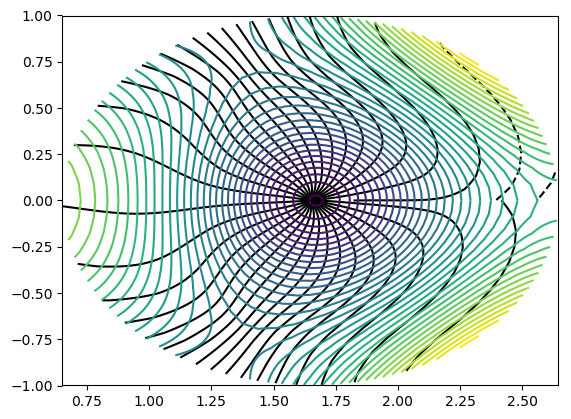

In [480]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],SA[:,:,1],40,colors="k")
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psit[:,:,1],40)
#PyPlot.xlim(1.6,1.8)
#PyPlot.ylim(-0.1,0.1)
PyPlot.show()

In [471]:
Pn = LinRange(0.0,1.0,101);
Ufn = LinRange(0.0,2*pi,udim);

In [501]:
function Project(Arr)
    PrjArr = Array{Float64}(undef,(size(Pn)[1],size(Ufn)[1],fidim,0))
    for t in 1:tdim
        PrjArrInPhi = Array{Float64}(undef,(size(Pn)[1],size(Ufn)[1],0))
        for phi_ind in 1:fidim
            pL = []
            ufL = []
            AL = []
            for r_ind in 1:rdim
                for u_ind in 1:udim
                    p = (psi[r_ind,u_ind,phi_ind,t] .- psi_min[t])/(norm[t] .- psi_min[t])
                    uf = SA[r_ind,u_ind,t]
                    A = Arr[r_ind,u_ind,phi_ind,t]
                    append!(pL,p)
                    append!(ufL,uf)
                    append!(AL,A)               
                end
            end
            #println(size(pL))
            #println(size())
            T = cat(dims=2,pL,ufL)
            ALf = Float64.(AL);
            pufpoints = Float64.(T');
            itp = ScatteredInterpolation.interpolate(ThinPlate(),pufpoints,ALf,smooth=0.8);
            PrA = []
            for p in Pn
                for uf in Ufn
                    proj = ScatteredInterpolation.evaluate(itp,[p,uf])
                    append!(PrA,proj)
                end
            end
            PrA = permutedims(reshape(PrA,size(Ufn)[1],size(Pn)[1]),(2,1));
            PrjArrInPhi = cat(dims=3,PrjArrInPhi,PrA)
        end
        PrjArr = cat(dims=4,PrjArr,PrjArrInPhi)
    end
    return PrjArr
end                     

Project (generic function with 1 method)

In [502]:
B3P = Project(B3)

101×65×65×6 Array{Any,4}:
[:, :, 1, 1] =
 0.0312376  0.0429204  0.0451816  …  0.0444922  0.0411947  0.0263258
 0.0402329  0.0516598  0.0536521     0.0531091  0.0501724  0.0355591
 0.0490704  0.0602636  0.0620304     0.0616358  0.0590167  0.0446164
 0.0577243  0.0687111  0.0702888     0.0700365  0.0676969  0.053478
 0.0661721  0.0769804  0.0783988     0.078279   0.0761836  0.0621255
 0.0743975  0.0850511  0.0863352  …  0.0863371  0.084452   0.0705433
 0.0823896  0.092906   0.0940771     0.0941901  0.0924836  0.07872
 0.0901423  0.100532   0.101609      0.101822   0.100265   0.0866481
 0.0976529  0.107919   0.108917      0.109221   0.107789   0.0943239
 0.104921   0.115062   0.115996      0.11638    0.11505    0.101747
 0.11195    0.121959   0.122839   …  0.123295   0.12205    0.108919
 0.118743   0.12861    0.129446      0.129965   0.12879    0.115843
 0.125304   0.13502    0.135817      0.136391   0.135275   0.122526
 ⋮                                ⋱                        
 0.396028

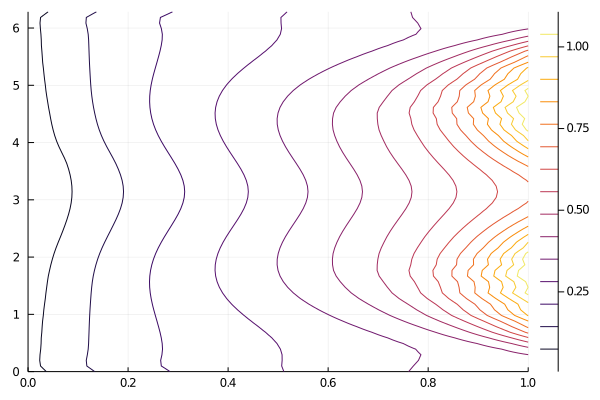

In [517]:
Plots.contour(Pn,Ufn,B3P[:,:,33,5]')

## Work with dictionary

In [94]:
function dict_interp(dictionary, psi, time, r, u, uf, l)
    dim_ext = length(r)-1
    
    r_of_l = Spline1D(l[1:dim_ext], r[1:dim_ext],bc="extrapolate")
    
    u_of_l = Spline1D(l[1:dim_ext], u[1:dim_ext],bc="extrapolate")
    
    l_of_u = Spline1D(u[1:dim_ext], l[1:dim_ext],bc="extrapolate")
    
    uf_of_l = Spline1D(l[1:dim_ext], uf[1:dim_ext],bc="extrapolate")
    
    dictionary[(string(psi),string(time))] = Dict("r_l"=>r_of_l, "u_l"=>u_of_l, "l_u"=>l_of_u, "uf_l"=>uf_of_l)
    return dictionary
end

dict_interp (generic function with 1 method)

In [430]:
function dictionary_creation()
    psi_dict = Dict()
    t_range = tdim
    DictTime=1
    psin_list = LinRange(0.0,1.0,101)
    for time in 1:t_range
        for r_ind in psi_min_ind:psi_max_ind
            psin = psin_list[r_ind]
            sol = fs_integration(r_of_psi_array[time,r_ind],0.0,time-1)
            r_sol = sol[1,:] 
            u_sol = sol[2,:]
            uf_sol = sol[3,:]
            q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
            uf_rsc_sol = uf_sol/q_redef
            l = sol.t
            try
                psi_dict = dict_interp(psi_dict, psin, time, r_sol, u_sol, uf_rsc_sol, l)
            catch
        
            end
            
        end
    end
    return psi_dict
end

dictionary_creation (generic function with 1 method)

In [116]:
loaded_dict = dictionary_creation();

In [268]:
function psi_proj(time)
    psin_list = LinRange(0.0,1.0,101)
    psi_dict_list = []
    uf_list = []
    psi_int_list = []
    ls = []
    
    key_list = [] # creating a list of keys for this time step
    for key in keys(loaded_dict)
        if key[2]==string(time)
            append!(key_list,key)
        end
    end
       
    for i in 1:2:size(key_list,1)
        l_min = loaded_dict[key_list[i],string(time)]["l_u"](0.001)
        l_max = loaded_dict[key_list[i],string(time)]["l_u"](6.28)
        ls = range(l_min,length=30,stop=l_max)
        for l in ls
            r = loaded_dict[key_list[i],string(time)]["r_l"](l)
            u = loaded_dict[key_list[i],string(time)]["u_l"](l)
            uf = loaded_dict[key_list[i],string(time)]["uf_l"](l)
            append!(psi_dict_list,parse(Float64,key_list[i]))
            append!(uf_list,uf)
            append!(psi_int_list,((psi_eint(r,u,0.0,time-1)-psi_min[time])/(norm[time][1]-psi_min[time])))
        end        
    end
    
    x=0.1 # Smoothing parameter of spline
    # spline is calculated on a shortened grid to avoid the magnetic axis and the edge
    spl = try
        Spline2D(psi_dict_list,uf_list,psi_int_list,s=x);
    catch
        try
            x = 2*x # keep doubling smoothing until it succeeds
            spl = Spline2D(psi_dict_list,uf_list,psi_int_list,s=x)
        catch
        end
    end
    PS_small = LinRange(psin_list[psi_min_ind],psin_list[psi_max_ind],psi_range)
    TF_small = range(minimum(uf_list),length=101,stop=maximum(uf_list))
    PS_large = LinRange(0,1,101)
    TF_large = LinRange(0,2*pi,101)
    zi = try
        Dierckx.evalgrid(spl,PS_small,TF_small);
    catch # If spline is of type Nothing, replace array with zeros 
        zi = zeros(Float64,(101,101))
    end
    # spline is extended to the full grid
    arr_int = interpolate(zi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))))
    arr_sint = scale(arr_int,PS_small,TF_small)
    arr_eint = extrapolate(arr_sint,(Line(),Periodic()))
    arr_rscld = []
    for i in PS_large
        for j in TF_large
            append!(arr_rscld,arr_eint(i,j))
        end
    end
    arr_rscld = permutedims(reshape(arr_rscld,(101,101)),(2,1))    
    return arr_rscld    
end

psi_proj (generic function with 1 method)

In [222]:
psi_proj(1);

In [269]:
function test_psi_proj(time)
    arr = psi_proj(time);
    PS = range(0,length=101,stop=1)
    TF = range(0,length=101,stop=2*pi)
    Plots.contour(PS,TF,arr')
end

test_psi_proj (generic function with 1 method)

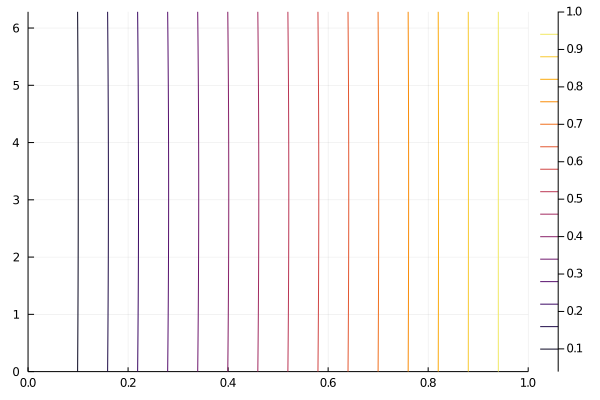

In [310]:
test_psi_proj(9)

In [644]:
B10 = @view B1[:,:,:,1];
B20 = @view B2[:,:,:,1];
B30 = @view B3[:,:,:,1];

In [645]:
na = [CartesianIndex()]

1-element Array{CartesianIndex{0},1}:
 CartesianIndex()

In [161]:
function proj_whole_array(arr,arr_eint)
    whole_array = Array{Float64}(undef,(psidim,udim,fidim,0))
    for t in 1:tdim
        whole_array_single_time = Array{Float64}(undef,(psidim,udim,0))
        for fi in 1:fidim        
            fi_log = (2*pi*(fi-1))/(fidim-1)
            temp = arr_proj_spline(arr_eint,fi_log,t)
            whole_array_single_time = cat(dims=3,whole_array_single_time,temp)
        end
        whole_array = cat(dims=4,whole_array,whole_array_single_time)
    end
    return whole_array
end            

proj_whole_array (generic function with 1 method)

In [433]:
function arr_proj_poly(arr_eint,phi,time)
    psin_list = LinRange(0.0,1.0,psidim)
    psi_list = []
    uf_list = []
    arr_int_list = []
    ls = []
    
    key_list = [] # creating a list of keys for this time step
    for key in keys(loaded_dict)
        if key[2]==string(time)
            append!(key_list,key)
        end
    end
    
    single_key_list = []
    for i in 1:2:size(key_list,1)
        append!(single_key_list,parse(Float64,key_list[i]))
    end
    sort!(single_key_list)

    
    for i in 1:size(single_key_list,1)
        l_min = loaded_dict[string(single_key_list[i]),string(time)]["l_u"](0.001)
        l_max = loaded_dict[string(single_key_list[i]),string(time)]["l_u"](6.28)
        ls = range(l_min,length=30,stop=l_max)
        for l in ls
            r = loaded_dict[string(single_key_list[i]),string(time)]["r_l"](l)
            u = loaded_dict[string(single_key_list[i]),string(time)]["u_l"](l)
            uf = loaded_dict[string(single_key_list[i]),string(time)]["uf_l"](l)
            append!(psi_list,single_key_list[i])
            append!(uf_list,uf)
            append!(arr_int_list,arr_eint(r,u,phi,time-1))
        end            
    end
    Points2D = cat(dims=2,psi_list,uf_list)
    Values = Float64.(arr_int_list);
    P2D = Float64.(Points2D');
    itp = ScatteredInterpolation.interpolate(Polyharmonic(2),P2D,Values,smooth=0.8);
    Proj = []
    for p in psin_list
        for uf in un
            pint = ScatteredInterpolation.evaluate(itp,[p,uf])
            append!(Proj,pint)
        end
    end
    Proj = permutedims(reshape(Proj,size(un)[1],size(psin_list)[1]),(2,1));
end

arr_proj_poly (generic function with 1 method)

In [432]:
function arr_proj_spline(arr_eint,phi,time)
    psin_list = LinRange(0.0,1.0,101)
    psi_list = []
    uf_list = []
    arr_int_list = []
    ls = []
    
    key_list = [] # creating a list of keys for this time step
    for key in keys(loaded_dict)
        if key[2]==string(time)
            append!(key_list,key)
        end
    end
    
    single_key_list = []
    for i in 1:2:size(key_list,1)
        append!(single_key_list,parse(Float64,key_list[i]))
    end
    sort!(single_key_list)
    
    for i in 1:size(single_key_list,1)
        l_min = loaded_dict[string(single_key_list[i]),string(time)]["l_u"](0.001)
        l_max = loaded_dict[string(single_key_list[i]),string(time)]["l_u"](6.28)
        ls = range(l_min,length=30,stop=l_max)
        for l in ls
            r = loaded_dict[string(single_key_list[i]),string(time)]["r_l"](l)
            u = loaded_dict[string(single_key_list[i]),string(time)]["u_l"](l)
            uf = loaded_dict[string(single_key_list[i]),string(time)]["uf_l"](l)
            append!(psi_list,single_key_list[i])
            append!(uf_list,uf)
            append!(arr_int_list,arr_eint(r,u,phi,time-1))
        end            
    end
    
    x=0.1 # Smoothing parameter of spline
    # spline is calculated on a shortened grid to avoid the magnetic axis and the edge
    spl = try
        Spline2D(psi_list,uf_list,arr_int_list,s=x);
    catch
        try
            x = 2*x # keep doubling smoothing until it succeeds
            spl = Spline2D(psi_list,uf_list,arr_int_list,s=x)
        catch
        end
    end
    PS_small = LinRange(psin_list[psi_min_ind],psin_list[psi_max_ind],psi_range)
    TF_small = range(minimum(uf_list),length=101,stop=maximum(uf_list))
    PS_large = LinRange(0,1,size(psin_list)[1])
    TF_large = LinRange(0,2*pi,size(un)[1])
    zi = try
        Dierckx.evalgrid(spl,PS_small,TF_small);
    catch # If spline is of type Nothing, replace array with zeros 
        zi = zeros(Float64,(size(psin_list[1]),size(un)[1]))
    end
    # spline is extended to the full grid
    arr_int = Interpolations.interpolate(zi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))))
    arr_sint = scale(arr_int,PS_small,TF_small)
    arr_eint = extrapolate(arr_sint,(Line(),Periodic()))
    arr_rscld = []
    for i in PS_large
        for j in TF_large
            append!(arr_rscld,arr_eint(i,j))
        end
    end
    arr_rscld = permutedims(reshape(arr_rscld,(size(un)[1],size(psin_list)[1])),(2,1))    
    return arr_rscld
end

arr_proj_spline (generic function with 1 method)

In [47]:
function arr_proj_tri(arr_eint,phi,time)
    psin_list = LinRange(0.0,1.0,psidim)
    psi_list = []
    uf_list = []
    arr_int_list = []
    ls = []
    
    key_list = [] # creating a list of keys for this time step
    for key in keys(loaded_dict)
        if key[2]==string(time)
            append!(key_list,key)
        end
    end
    
    single_key_list = []
    for i in 1:2:size(key_list,1)
        append!(single_key_list,parse(Float64,key_list[i]))
    end
    sort!(single_key_list)

    
    for i in 1:size(single_key_list,1)
        l_min = loaded_dict[string(single_key_list[i]),string(time)]["l_u"](0.001)
        l_max = loaded_dict[string(single_key_list[i]),string(time)]["l_u"](6.28)
        ls = range(l_min,length=30,stop=l_max)
        for l in ls
            r = loaded_dict[string(single_key_list[i]),string(time)]["r_l"](l)
            u = loaded_dict[string(single_key_list[i]),string(time)]["u_l"](l)
            uf = loaded_dict[string(single_key_list[i]),string(time)]["uf_l"](l)
            append!(psi_list,single_key_list[i])
            append!(uf_list,uf)
            append!(arr_int_list,arr_eint(r,u,phi,time-1))
        end            
    end
    
    Proj = []
    triangObj = tri.Triangulation(psi_list,uf_list)
    tcp = tri.CubicTriInterpolator(triangObj,arr_int_list)
    for p in psin_list
        for uf in un
            pint = tcp(p,uf)
            append!(Proj,pint)
        end
    end
    Proj = permutedims(reshape(Proj,size(un)[1],size(psin_list)[1]),(2,1));
    return Proj
end

arr_proj_tri (generic function with 1 method)

In [48]:
Atri = arr_proj_tri(B3_eint,0,2);

In [134]:
Aspl = arr_proj_spline(B2_eint,0,2);

In [149]:
Apoly = arr_proj_poly(B3_eint,0,2);

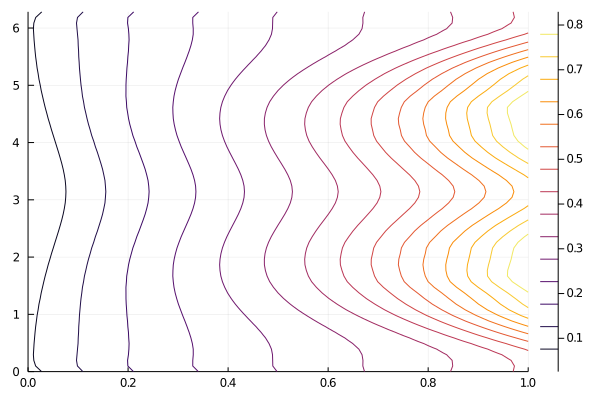

In [150]:
PS = range(0,length=101,stop=1)
TF = range(0,length=size(un)[1],stop=2*pi)
Plots.contour(PS,TF,Apoly')

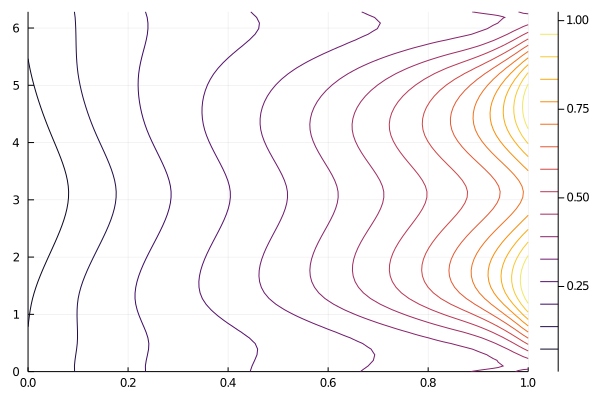

In [52]:
Plots.contour(PS,TF,Aspl')

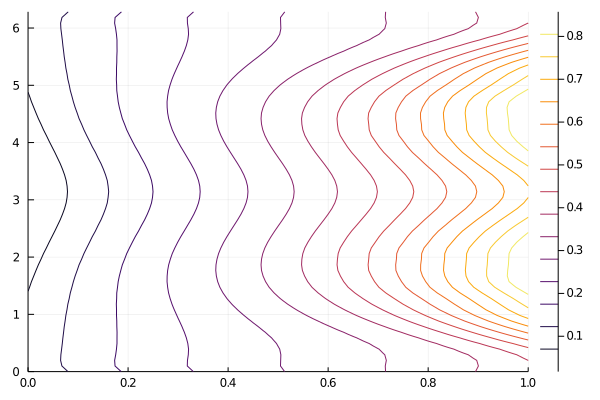

In [53]:
Plots.contour(PS,TF,Apoly')

## $\hat{b}^{\rho}$ calculation

In [686]:
na = [CartesianIndex()]

1-element Array{CartesianIndex{0},1}:
 CartesianIndex()

In [687]:
dB1 = B1.-B1t[:,:,na,:];
dB2 = B2.-B2t[:,:,na,:];    
dB3 = B3.-B3t[:,:,na,:];

In [695]:
brho = dB1.*B2t[:,:,na,:] .- dB2.*B1t[:,:,na,:];
b_hat_rho = brho./B3t[:,:,na,:];

# Interpolate b_hat_rho
b_hat_rho_int = Interpolations.interpolate(b_hat_rho[2:end,:,:,:],(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
b_hat_rho_sint = scale(b_hat_rho_int, rn[2:end],un,phin,tn);
b_hat_rho_eint = extrapolate(b_hat_rho_sint, (Line(),Periodic(),Periodic(),Line()));

In [696]:
b_hat_rho = b_hat_rho_eint(rn,un,phin,tn)

129×65×33×5 Array{Float64,4}:
[:, :, 1, 1] =
  0.000444662   0.000443064   0.000441826  …   0.000446267   0.000444662
  0.000418814   0.000410408   0.000402803      0.000427018   0.000418814
  0.000392311   0.000377082   0.000363107      0.000407096   0.000392311
  0.000362993   0.000341012   0.000320774      0.000384125   0.000362993
  0.00033195    0.000303847   0.00027791       0.000358664   0.00033195
  0.000299343   0.000265815   0.000234769  …   0.000330844   0.000299343
  0.000265545   0.000227385   0.000191854      0.000300972   0.000265545
  0.000230879   0.000188991   0.000149635      0.000269283   0.000230879
  0.000195816   0.000151193   0.000108692      0.000236176   0.000195816
  0.000160892   0.000114622   6.96797e-5       0.000202094   0.000160892
  0.000126775   8.0026e-5     3.33531e-5   …   0.000167613   0.000126775
  9.42296e-5    4.82429e-5    5.40117e-7       0.000133386   9.42296e-5
  6.4115e-5     2.01834e-5   -2.78687e-5       0.000100167   6.4115e-5
  ⋮       

In [697]:
function project(arr_eint)
    ArrP = []
    uf_pts = LinRange(0.0,2*pi,udim)
    phi_pts = LinRange(0.0,2*pi,fidim)
    for t in 1:tdim
        for p in pn[1:psi_max_ind]
            for uf in uf_pts
                for phi in phi_pts
                    if p == 0.0
                        r = rmaxis[t]
                        u = umaxis[t]
                        ArrVal = arr_eint(r,u,phi,t-1)
                        append!(ArrP,ArrVal)
                    else
                        r = GD[Int64(t-1),round(p,digits=2),Float64(uf)][1]
                        u = GD[Int64(t-1),round(p,digits=2),Float64(uf)][2]
                        ArrVal = arr_eint(r,u,phi,t-1)
                        append!(ArrP,ArrVal)
                    end
                end
            end
        end
    end
    Arr = permutedims(reshape(ArrP,size(phi_pts)[1],size(uf_pts)[1],size(pn)[1]-1,tdim),(3,2,1,4))
    return Arr
end

project (generic function with 1 method)

In [698]:
b_hat_rho_P = project(b_hat_rho_eint);

In [699]:
size(b_hat_rho_P)

(100, 65, 33, 5)

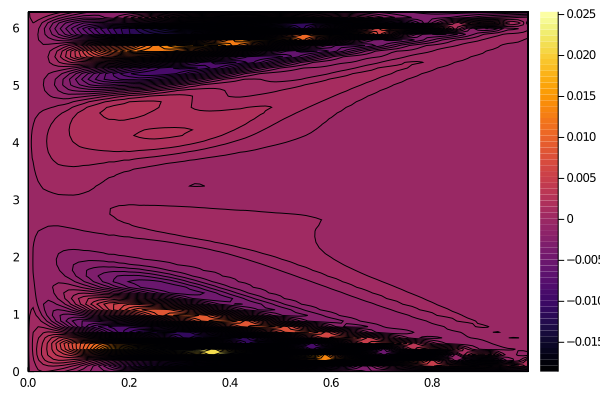

In [700]:
Plots.contourf(pn[1:psi_max_ind],un,b_hat_rho_P[:,:,1,3]',levels=60)
#xlims!(0.0,0.1)
#ylims!(2.8,3.6)

In [612]:
size(Q)

(101, 65, 33, 40)

In [701]:
b_hat_rho_ncq = -Q[1:end-1,:,:,:].*b_hat_rho_P

100×65×33×5 Array{Float64,4}:
[:, :, 1, 1] =
  9.35982e-6    9.35982e-6    9.35982e-6  …   9.35982e-6    9.35982e-6
  0.000910733   0.00111334    0.00140681      0.000588617   0.000879575
  0.00130287    0.00181661    0.00265431      0.000599971   0.0013305
  0.0013954     0.0023245     0.00375289      0.000148721   0.00144113
  0.00134669    0.00270534    0.00455659     -0.000437656   0.00131236
  0.00104909    0.00277192    0.00503864  …  -0.00112149    0.00102732
  0.000693004   0.00265872    0.00520771     -0.00181851    0.000649276
  0.00023583    0.00231126    0.00513908     -0.00241978    0.000219629
 -0.000185616   0.00191336    0.00489237     -0.00294693   -0.000233573
 -0.000570211   0.00143984    0.00449531     -0.00350668   -0.000710915
 -0.00111505    0.000664575   0.00403312  …  -0.00370719   -0.00116877
 -0.00153473   -0.000176968   0.00334515     -0.00385619   -0.00157297
 -0.00191119   -0.00111297    0.00236878     -0.00386639   -0.00191765
  ⋮                         

In [618]:
npzwrite("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/" * "b_hat_rho.npy",Float64.(b_hat_rho_ncq))

In [1491]:
npzwrite("/net/scratch3/giannis_kx/pixie3d/tests/sawtooth/python_arrays/" * "b_hat_rhoq_small.npy",Float64.(b_hat_rho_ncq))

In [702]:
npzwrite("/net/scratch3/giannis_kx/pixie3d/tests/sawtooth/python_arrays/" * "b_hat_rho_small.npy",Float64.(b_hat_rho_P))

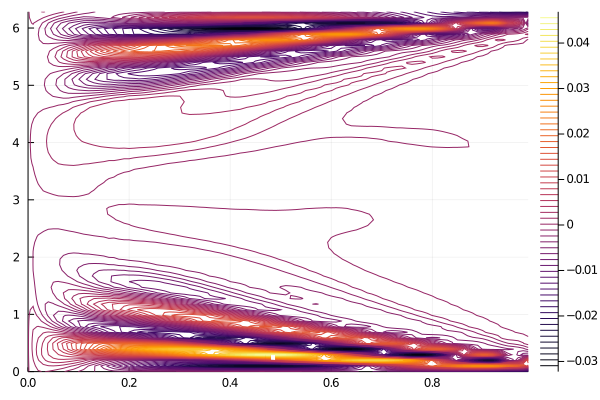

In [703]:
Plots.contour(pn[1:psi_max_ind],un,b_hat_rho_ncq[:,:,1,3]',levels=60)
#xlims!(0.0,0.6)

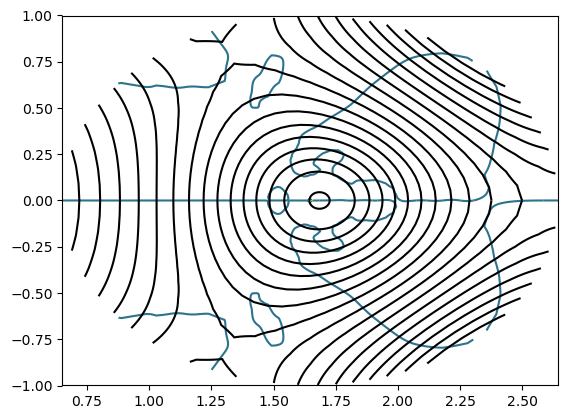

In [1100]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],b_hat_rho[:,:,1,2],80)
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],psi[:,:,1,2],20,colors="k")
PyPlot.show()

In [1124]:
# Interpolate b_hat_rho_P
b_hat_rho_P_int = Interpolations.interpolate(Float64.(b_hat_rho_P),(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
b_hat_rho_P_sint = scale(b_hat_rho_P_int, pn[psi_min_ind:psi_max_ind],ufn,phin,tn);
b_hat_rho_P_eint = extrapolate(b_hat_rho_P_sint, (Line(),Periodic(),Periodic(),Line()));

In [1125]:
b_hat_rho_P_ext = b_hat_rho_P_eint(pn,ufn,phin,tn)

101×65×65×5 Array{Float64,4}:
[:, :, 1, 1] =
  4.77589e-8  -3.53735e-6  -9.03887e-6  …   3.94884e-6   4.77589e-8
  3.80996e-7  -3.86874e-6  -8.5961e-6       4.31044e-6   3.80996e-7
  7.14234e-7  -4.20014e-6  -8.15333e-6      4.67205e-6   7.14234e-7
  1.04747e-6  -4.53153e-6  -7.71057e-6      5.03366e-6   1.04747e-6
  1.29184e-6  -4.76397e-6  -7.24952e-6      5.26605e-6   1.29184e-6
  1.14812e-6  -4.69401e-6  -6.94329e-6  …   5.07433e-6   1.14812e-6
  7.7168e-7   -4.79689e-6  -7.38243e-6      5.02755e-6   7.7168e-7
  3.3032e-7   -4.47933e-6  -7.20881e-6      4.58811e-6   3.3032e-7
 -2.2614e-9   -3.69064e-6  -5.95533e-6      3.72655e-6  -2.2614e-9
 -1.45309e-7  -3.11259e-6  -4.841e-6        3.12601e-6  -1.45309e-7
 -1.54987e-7  -2.99576e-6  -4.39678e-6  …   3.00808e-6  -1.54987e-7
 -1.06598e-7  -3.09568e-6  -4.31741e-6      3.11101e-6  -1.06598e-7
 -4.39256e-8  -3.14331e-6  -4.28972e-6      3.16534e-6  -4.39256e-8
  ⋮                                     ⋱               
  1.19567e-8   6.

In [1126]:
b_hat_rho_ncq_ext = -Q[:,:,:,:].*b_hat_rho_P_ext

101×65×65×5 Array{Float64,4}:
[:, :, 1, 1] =
  4.62671e-8  -3.42686e-6  -8.75653e-6  …   3.82549e-6   4.62671e-8
  3.69476e-7  -3.75176e-6  -8.33617e-6      4.18011e-6   3.69476e-7
  6.9335e-7   -4.07733e-6  -7.91493e-6      4.53544e-6   6.9335e-7
  1.01789e-6  -4.40355e-6  -7.4928e-6       4.8915e-6    1.01789e-6
  1.25671e-6  -4.63444e-6  -7.0524e-6       5.12286e-6   1.25671e-6
  1.11845e-6  -4.57269e-6  -6.76384e-6  …   4.94318e-6   1.11845e-6
  7.53134e-7  -4.6816e-6   -7.205e-6        4.90671e-6   7.53134e-7
  3.23168e-7  -4.38235e-6  -7.05274e-6      4.48878e-6   3.23168e-7
 -2.21937e-9  -3.62204e-6  -5.84464e-6      3.65729e-6  -2.21937e-9
 -1.43172e-7  -3.06682e-6  -4.76983e-6      3.08005e-6  -1.43172e-7
 -1.53447e-7  -2.966e-6    -4.35311e-6  …   2.9782e-6   -1.53447e-7
 -1.06143e-7  -3.08245e-6  -4.29896e-6      3.09771e-6  -1.06143e-7
 -4.40279e-8  -3.15063e-6  -4.29972e-6      3.17271e-6  -4.40279e-8
  ⋮                                     ⋱               
  4.94879e-8   

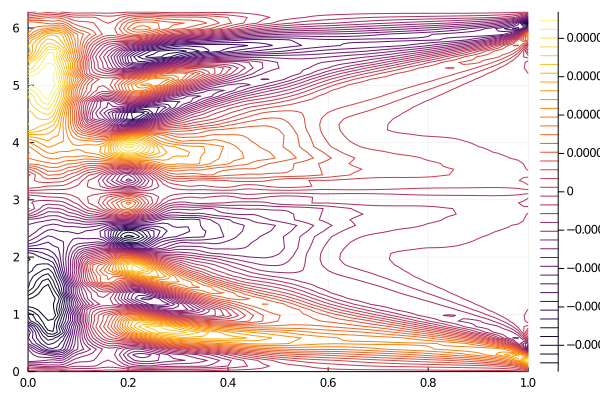

In [1132]:
Plots.contour(pn,un,b_hat_rho_ncq_ext[:,:,1,3]',levels=40)
#xlims!(0.0,0.1)

In [1129]:
npzwrite("/net/scratch3/giannis_kx/pixie3d/tests/sawtooth/python_arrays/" * "b_hat_rho_ext.npy",b_hat_rho_ncq_ext)

In [1101]:
size(b_hat_rho_ncq_ext)

(101, 65, 65, 5)

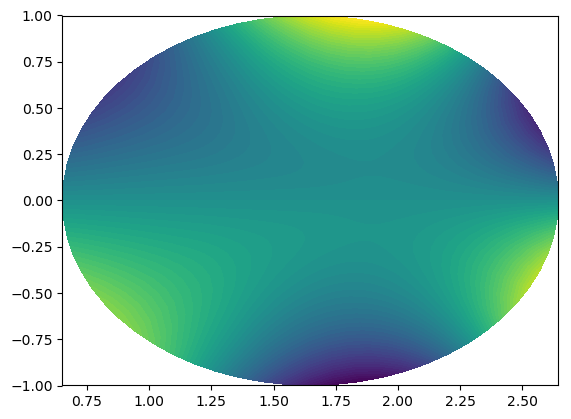

In [1392]:
PyPlot.contourf(pxr.X[:,:,1],pxr.Z[:,:,1],B1[:,:,1,1],60)
PyPlot.show()

In [1390]:
size(B1)

(129, 65, 65, 6)

In [1401]:
B3P = project(B3_eint)

99×65×65×6 Array{Any,4}:
[:, :, 1, 1] =
 0.0934301  0.0933643  0.0931211  …  0.0931367  0.0933711  0.0934303
 0.106663   0.106581   0.106274      0.106286   0.106587   0.106663
 0.116644   0.116553   0.116211      0.116227   0.11656    0.116644
 0.125102   0.125005   0.124643      0.124654   0.12501    0.125102
 0.132559   0.132463   0.132091      0.132099   0.132466   0.132559
 0.139275   0.139175   0.138795   …  0.138804   0.139179   0.139275
 0.145427   0.145329   0.144947      0.144949   0.145329   0.145427
 0.151154   0.151056   0.150674      0.150677   0.151057   0.151154
 0.156553   0.156454   0.156069      0.156077   0.156458   0.156553
 0.161677   0.161582   0.161197      0.161204   0.161585   0.161677
 0.166569   0.166484   0.166103   …  0.166098   0.16648    0.166568
 0.17126    0.171179   0.170801      0.170794   0.171174   0.171259
 0.175762   0.175687   0.175315      0.175302   0.175679   0.17576
 ⋮                                ⋱                        
 0.3992     0.39

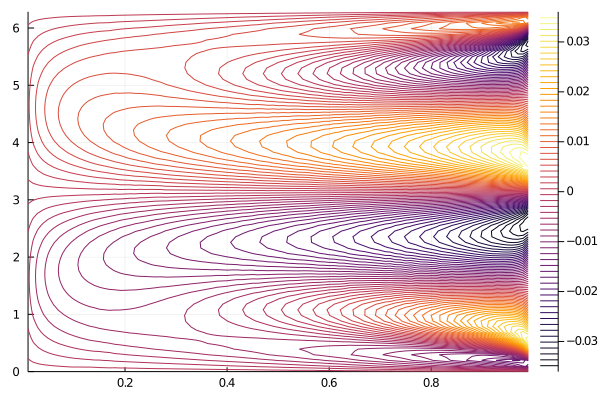

In [1410]:
Plots.contour(Pn[psi_min_ind:psi_max_ind],un,B1P[:,:,1,1]',levels=60)
#xlims!(0.0,0.1)
#ylims!(2.8,3.6)

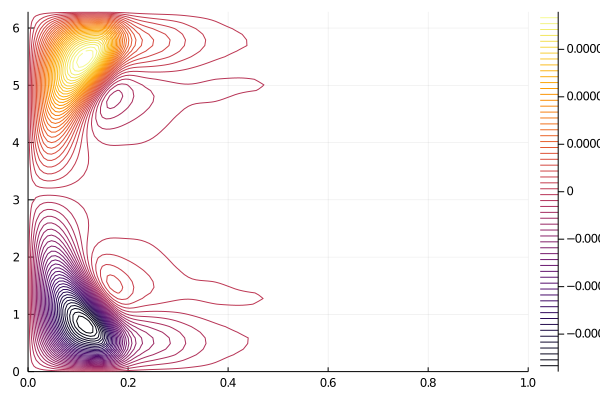

In [1480]:
Plots.contour(rn[1:end],un,b_hat_rho[1:end,:,1,6]',levels=60)
#xlims!(0.0,0.1)
#ylims!(2.8,3.6)

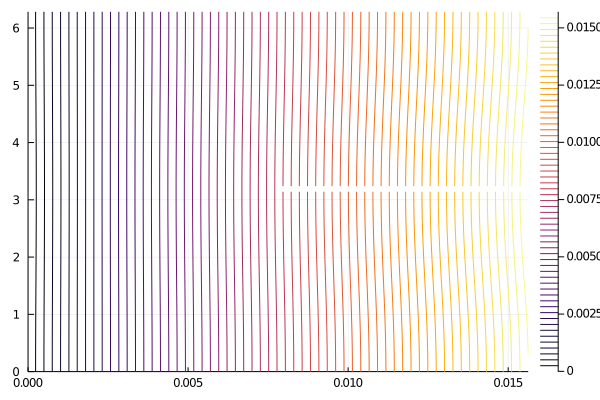

In [1446]:
Plots.contour(rn[1:3],un,B3t[1:3,:,1]',levels=60)

In [1460]:
B3t[1,32,1]

-1.186979352749281e-5

In [1452]:
brho[2,32,1,1]

-3.917748521069531e-9

In [1454]:
b_hat_rho[2,32,1,1]

-5.010499721638222e-7

In [1455]:
-3.917748521069531e-9/0.007819077414874285

-5.010499721638222e-7

In [70]:
convert(Int,ceil(64/2))

32

In [1047]:
ratio1 = B1t./B2t;
ratio2 = B2t./B1t;

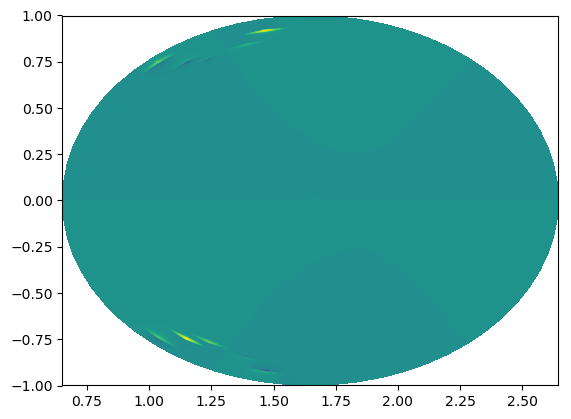

In [1054]:
PyPlot.contourf(pxr.X[:,:,1],pxr.Z[:,:,1],ratio1[:,:,3],100)
PyPlot.show()

## Checking $B_p$

In [2016]:
B2p_metric = grrN[:,:,na].*(B1[:,:,1,:]).^2 + 2*grtN[:,:,na].*B1[:,:,1,:].*B2[:,:,1,:] + gttN[:,:,na].*(B2[:,:,1,:]).^2; 

In [2015]:
B2p = B1.*B_1 + B2.*B_2;

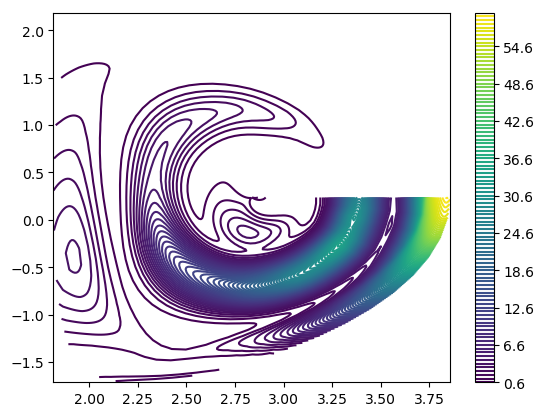

In [2017]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B2p_metric[:,:,2],100)
PyPlot.colorbar()
PyPlot.show()

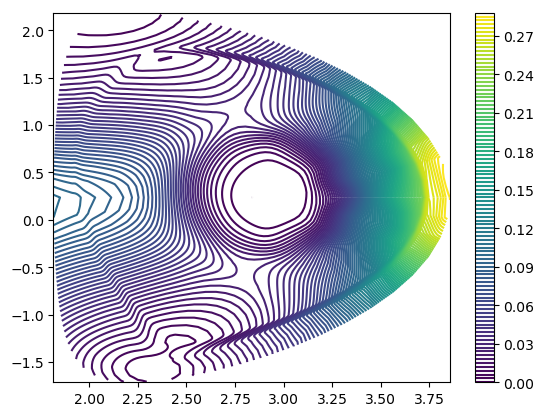

In [2018]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B2p[:,:,1,2],100)
PyPlot.colorbar()
PyPlot.show()

In [2027]:
B1abs = B1.*B_1;
B1abs2 = B1.*grrN[:,:,na,na].*B1;
B1absder = B1.*grr_derived.*B1;

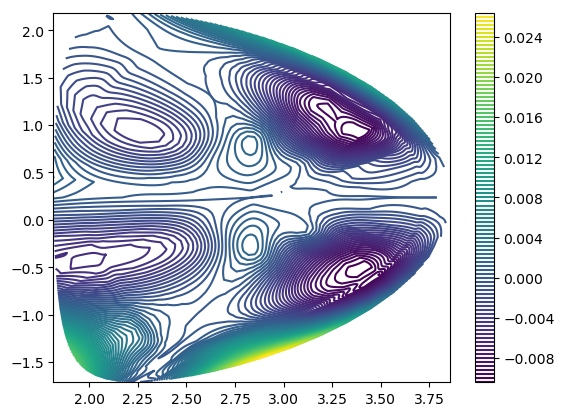

In [2024]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B1abs[:,:,1,2],100)
PyPlot.colorbar()
PyPlot.show()

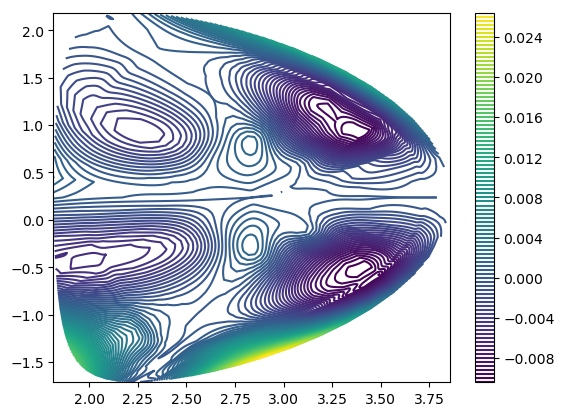

In [2037]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B1absder[:,:,1,2],100)
PyPlot.colorbar()
PyPlot.show()

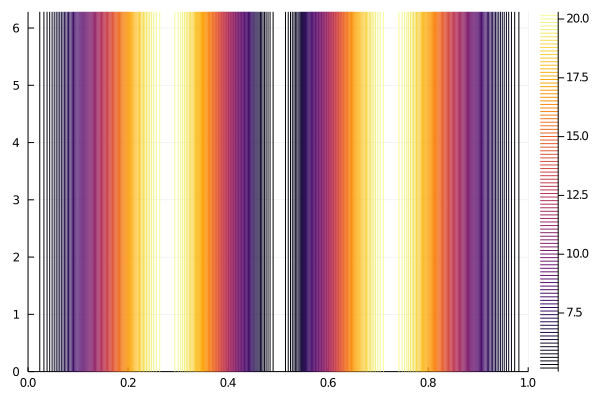

In [2029]:
Plots.contour(rn[1:end],un[1:end],grrN'[1:end,1:end],levels=100)

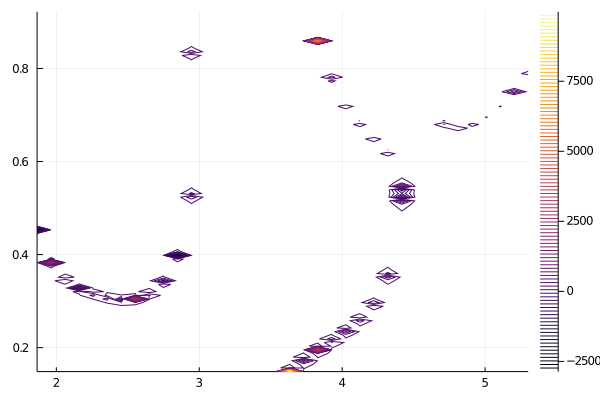

In [2036]:
Plots.contour(un[20:end-10],rn[20:end-10],grr_derived[20:end-10,20:end-10,1,1],levels=100)

In [2026]:
grr_derived = B_1./B1

129×65×33×5 Array{Float64,4}:
[:, :, 1, 1] =
 7015.87       -2398.66      -5114.15     …  -59184.8      7015.87
   23.7643       -36.3191     2011.99            43.2528     23.7643
   11.8396       -17.5573      529.818           21.0526     11.8396
    7.87246      -11.1761      235.894           13.6439      7.87246
    5.88779       -7.87946     133.589            9.93593     5.88779
    4.69726       -5.82091      86.0229   …       7.70968     4.69726
    3.90351       -4.38338      60.1169           6.22493     3.90351
    3.33655       -3.30575      44.4253           5.16461     3.33655
    2.9113        -2.45948      34.1927           4.37005     2.9113
    2.58053       -1.77412      27.1428           3.753       2.58053
    2.31586       -1.20705      22.0845   …       3.26055     2.31586
    2.09929       -0.731384     18.3377           2.85894     2.09929
    1.91878       -0.329628     15.4918           2.5256      1.91878
    ⋮                                     ⋱        

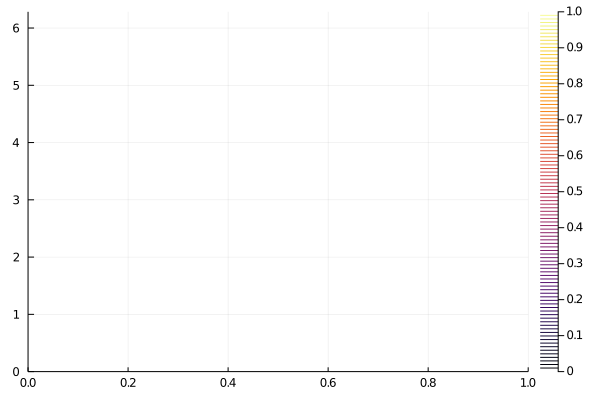

In [1975]:
Plots.contour(rn[1:end],un[1:end],gtt_derived'[:,:],levels=100)

In [1991]:
deltab1 = B1.-B_1

128×64×32×5 Array{Float64,4}:
[:, :, 1, 1] =
 0.000375298  -0.0075807   -0.0154705   …   0.0162011    0.00832818
 0.000325577  -0.00730818  -0.0148916       0.015511     0.00795626
 0.000296078  -0.00701583  -0.014296        0.0148369    0.00760396
 0.000279936  -0.00671009  -0.0136904       0.014171     0.00726379
 0.000275111  -0.0063916   -0.0130732       0.0135091    0.006932
 0.00028009   -0.00605924  -0.0124403   …   0.0128446    0.00660429
 0.000293873  -0.00571165  -0.0117876       0.0121714    0.00627682
 0.000314776  -0.00534778  -0.0111113       0.0114836    0.00594537
 0.000341384  -0.00496645  -0.0104071       0.0107757    0.00560614
 0.000372175  -0.00456718  -0.00967259      0.0100435    0.00525572
 0.000405989  -0.00414931  -0.00890556  …   0.00928287   0.00489098
 0.000441338  -0.00371345  -0.00810607      0.00849176   0.00450987
 0.000476882  -0.00326025  -0.00727486      0.00766939   0.00411092
 ⋮                                      ⋱               
 0.0155068     0

In [2014]:
deltab2 = B2.-B_2

129×65×33×5 Array{Float64,4}:
[:, :, 1, 1] =
  0.123395    0.125208    0.125817   …   0.11623     0.120392    0.123395
  0.117297    0.119058    0.11957        0.110062    0.114284    0.117297
  0.111271    0.112997    0.113429       0.103923    0.108227    0.111271
  0.105336    0.10705     0.107423       0.0978191   0.102234    0.105336
  0.0994608   0.10118     0.101511       0.091728    0.0962766   0.0994608
  0.0936134   0.095356    0.0956644  …   0.0856247   0.090327    0.0936134
  0.0877513   0.0895353   0.0898378      0.0794767   0.0843466   0.0877513
  0.0818344   0.0836747   0.0839881      0.0732563   0.0783009   0.0818344
  0.0758253   0.0777338   0.0780746      0.0669394   0.0721589   0.0758253
  0.0696905   0.0716775   0.0720633      0.0605087   0.0658942   0.0696905
  0.0634039   0.0654779   0.0659293  …   0.0539568   0.059489    0.0634039
  0.05695     0.0591173   0.0596563      0.0472827   0.0529345   0.05695
  0.0503229   0.0525856   0.0532371      0.0404966   0.046233